# Using time series analysis for sales and demand forecasting

In [1]:
import requests
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.interpolate import UnivariateSpline, PchipInterpolator # Univariate spline not used as leads to values >0
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
import tensorflow as tf
import random
import keras_tuner as kt

# Suppress all warnings in the Jupyter notebook
warnings.filterwarnings('ignore')

C:\Users\alger\AppData\Local\Temp\ipykernel_6080\3337564202.py:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


#### Download the datasets to local drive

This only needs to be run once

In [2]:
# List of files with their IDs and desired filenames
files = [
    {
        'file_id': '1P7HwOIrJuk1n9JCW81xiNBSP7LUfaW57',
        'filename': 'isbn.xlsx'
    },
    {
        'file_id': '16Hw57l_-Bc2OSHefYg6Sg9UpUuAiezJt',
        'filename': 'tsdata.xlsx'
    }
]

In [3]:
for file in files:
    file_id = file['file_id']
    filename = file['filename']
    # Export URL for XLSX format
    export_url = f'https://docs.google.com/spreadsheets/d/{file_id}/export?format=xlsx'

    # Send the GET request
    response = requests.get(export_url)

    # Check if the request was successful
    if response.status_code == 200:
        # Save the content to a file
        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f"Download complete: '{filename}'")
    else:
        print(f"An error occurred while downloading {filename}: HTTP {response.status_code}")

Download complete: 'isbn.xlsx'
Download complete: 'tsdata.xlsx'


#### Concatenate all sales data tabs into a single dataframe

This code retains the tab name as the new 'Product Category' column

In [4]:
# Excel file path
excel_file = 'tsdata.xlsx'

# Read all sheets from the Excel file into a dictionary of DataFrames
dfs = pd.read_excel(excel_file, sheet_name=None)

# Initialize an empty list to store the DataFrames
df_list = []

# Loop through each sheet
for sheet_name, df in dfs.items():
    # Add a new column 'Product Category' with the sheet name
    df['Product Category'] = sheet_name
    # Append the modified DataFrame to the list
    df_list.append(df)

# Concatenate all DataFrames into one
total_sales_data = pd.concat(df_list, ignore_index=True)

total_sales_data

,ISBN,Title,Author,Interval,End Date,Volume,Value,ASP,RRP,Binding,Imprint,Publisher Group,Product Class,Product Category
0,9780002261821,One For My Baby,"Parsons, Tony",200513,2005-04-02,1,15.99,15.9900,15.99,Hardback,HarperCollins Publishers,HarperCollins Grp,F1.1 General & Literary Fiction,F Adult Fiction
1,9780002261821,One For My Baby,"Parsons, Tony",200503,2005-01-22,1,15.99,15.9900,15.99,Hardback,HarperCollins Publishers,HarperCollins Grp,F1.1 General & Literary Fiction,F Adult Fiction
2,9780002261821,One For My Baby,"Parsons, Tony",200422,2004-05-29,1,11.19,11.1900,15.99,Hardback,HarperCollins Publishers,HarperCollins Grp,F1.1 General & Literary Fiction,F Adult Fiction
3,9780002261821,One For My Baby,"Parsons, Tony",200415,2004-04-10,2,27.18,13.5900,15.99,Hardback,HarperCollins Publishers,HarperCollins Grp,F1.1 General & Literary Fiction,F Adult Fiction
4,9780002261821,One For My Baby,"Parsons, Tony",200404,2004-01-24,2,22.48,11.2400,15.99,Hardback,HarperCollins Publishers,HarperCollins Grp,F1.1 General & Literary Fiction,F Adult Fiction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227219,9781903840122,"Wicked Book of Txt Tlk, The",NaN,200112,2001-03-24,693,1377.31,1.9875,1.99,Paperback,Buster Books,Michael O'Mara Grp,Y4.1 Children's General Interest & Leisure,"Y Children's, YA & Educational"
227220,9781903840122,"Wicked Book of Txt Tlk, The",NaN,200111,2001-03-17,638,1269.23,1.9894,1.99,Paperback,Buster Books,Michael O'Mara Grp,Y4.1 Children's General Interest & Leisure,"Y Children's, YA & Educational"
227221,9781903840122,"Wicked Book of Txt Tlk, The",NaN,200110,2001-03-10,850,1691.50,1.9900,1.99,Paperback,Buster Books,Michael O'Mara Grp,Y4.1 Children's General Interest & Leisure,"Y Children's, YA & Educational"
227222,9781903840122,"Wicked Book of Txt Tlk, The",NaN,200109,2001-03-03,517,1027.25,1.9869,1.99,Paperback,Buster Books,Michael O'Mara Grp,Y4.1 Children's General Interest & Leisure,"Y Children's, YA & Educational"


#### Converting columns to correct data type

In [5]:
# Convert 'ISBN' column to string
total_sales_data['ISBN'] = total_sales_data['ISBN'].astype(str)

# Convert 'End Date' column to datetime
total_sales_data['End Date'] = pd.to_datetime(total_sales_data['End Date'], errors='coerce')

#### Adding missing weeks where sales were 0

For simplicity we are adding all weeks from January 2010 to July 2024, regardless of when a book was published. 

In [6]:
# Set 'ISBN' and 'End Date' as a MultiIndex
total_sales_data = total_sales_data.set_index(['ISBN', 'End Date'])

In [7]:
# Generate a date range of all Saturdays in the specified period
all_saturdays = pd.date_range(start='2001-01-06', end='2024-07-20', freq='W-SAT')

# Get unique ISBNs
unique_isbns = total_sales_data.index.get_level_values('ISBN').unique()

# Create a MultiIndex from all ISBNs and all Saturdays
multi_index = pd.MultiIndex.from_product([unique_isbns, all_saturdays], names=['ISBN', 'End Date'])

# Reindex the DataFrame to include all ISBN and End Date combinations
total_sales_data = total_sales_data.reindex(multi_index)

# Reset index to turn 'ISBN' and 'End Date' back into columns
total_sales_data = total_sales_data.reset_index(drop=False)

In [8]:
# Ensure 'End Date' is a datetime object
total_sales_data['End Date'] = pd.to_datetime(total_sales_data['End Date'])

# Recreate 'Interval' column from 'End Date'
total_sales_data['Year'] = total_sales_data['End Date'].dt.year

# Calculate the week number for each 'End Date' (weeks starting on Sunday)
total_sales_data['Week'] = total_sales_data['End Date'].dt.strftime('%U').astype(int) + 1

# Create 'Interval' column in 'YYYYWW' format
total_sales_data['Interval'] = total_sales_data['Year'].astype(str) + \
    total_sales_data['Week'].astype(str).str.zfill(2)

# Drop the 'Year' and 'Week' columns
total_sales_data = total_sales_data.drop(columns=['Year', 'Week'])

In [9]:
# Fill NaN values in the 'Volume', 'Value', and 'ASP' columns with 0
total_sales_data[['Volume', 'Value', 'ASP']] = total_sales_data[['Volume', 'Value', 'ASP']].fillna(0)

total_sales_data

,ISBN,End Date,Title,Author,Interval,Volume,Value,ASP,RRP,Binding,Imprint,Publisher Group,Product Class,Product Category
0,9780002261821,2001-01-06,NaN,NaN,200101,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,9780002261821,2001-01-13,NaN,NaN,200102,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,9780002261821,2001-01-20,NaN,NaN,200103,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,9780002261821,2001-01-27,NaN,NaN,200104,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,9780002261821,2001-02-03,NaN,NaN,200105,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614495,9781903840122,2024-06-22,NaN,NaN,202425,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
614496,9781903840122,2024-06-29,NaN,NaN,202426,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
614497,9781903840122,2024-07-06,NaN,NaN,202427,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
614498,9781903840122,2024-07-13,NaN,NaN,202428,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Now we will merge the ISBN workbooks. This table will be used to complete any missing NaN values in total_sales_data, as well as provide new columns unavailable in the original time series dataset. 

The end result will be a single dataframe containing all information available from both excel files. Will this complete dataset be useful? Likely no, however it will be a good base from which smaller, more useful datasets can be created.

We start by merging the isbn.xlsx sheets

In [10]:
# Excel file path
excel_file = 'isbn.xlsx'

# Read all sheets from the Excel file into a dictionary of DataFrames
dfs = pd.read_excel(excel_file, sheet_name=None)

# Initialize an empty list to store the DataFrames
df_list = []

# Loop through each sheet
for sheet_name, df in dfs.items():
    # Add a new column 'Product Category' with the sheet name
    df['Product Category'] = sheet_name
    # Append the modified DataFrame to the list
    df_list.append(df)

# Concatenate all DataFrames into one
isbn = pd.concat(df_list, ignore_index=True)

# Convert 'ISBN' column to string
isbn['ISBN'] = isbn['ISBN'].astype(str)

isbn

,ISBN,Title,Author,Imprint,Publisher Group,RRP,Binding,Publication Date,Product Class,Country of Publication,Product Category
0,9780330375252,Bridget Jones's Diary (Film Tie-in),"Fielding, Helen",Picador,Pan Macmillan Grp,8.99,Paperback,2001-03-23,F1.1 General & Literary Fiction,United Kingdom,F - Adult Fiction
1,9780140276336,White Teeth,"Smith, Zadie",Penguin Books Ltd,Penguin Grp,9.99,Paperback,2001-01-25,F1.1 General & Literary Fiction,United Kingdom,F - Adult Fiction
2,9780006512134,Man and Boy,"Parsons, Tony",HarperCollins Publishers,HarperCollins Grp,8.99,Paperback,2000-03-06,F1.1 General & Literary Fiction,United Kingdom,F - Adult Fiction
3,9780099280255,"Brethren,The","Grisham, John",Arrow Books,Random House Grp,6.99,Paperback,2000-12-27,"F2.1 Crime, Thriller & Adventure",United Kingdom,F - Adult Fiction
4,9780552998727,Marrying The Mistress:an irresistible and grip...,"Trollope, Joanna",Black Swan,Transworld Grp,10.99,Paperback,2001-02-01,F1.1 General & Literary Fiction,United Kingdom,F - Adult Fiction
...,...,...,...,...,...,...,...,...,...,...,...
495,9781854306838,Laura's Christmas Star:Laura's Star,"Baumgart, Klaus",Little Tiger Press,Little Tiger Press Group,5.99,Paperback,2001-09-28,Y1.3 Picture Books,United Kingdom,"Y Children's, YA & Educational"
496,9780723245995,Where's Spot,"Hill, Eric",F Warne Publishers Ltd,Penguin Grp,4.99,Hardback,2000-03-13,Y1.1 Pre-school & Early Learning,United Kingdom,"Y Children's, YA & Educational"
497,9781902836553,Action Man Annual:2002,NaN,Pedigree Books,Pedigree Grp,6.99,Hardback,2001-09-08,Y4.1 Children's General Interest & Leisure,United Kingdom,"Y Children's, YA & Educational"
498,9781841462400,KS3 Science Revision Guide – Foundation (inclu...,CGP Books,Coordination Group Publications Ltd (CGP),Coordination Group Publications,6.50,Hardback,2023-05-23,"Y5.3 School Textbooks & Study Guides: Maths, S...",United Kingdom,"Y Children's, YA & Educational"


Now we check if both dataframes (isbn and total_sales_data) have the same number of unique ISBNs

In [11]:
# Ensure that the 'ISBN' columns are standardized
total_sales_data['ISBN'] = total_sales_data['ISBN'].astype(str).str.strip()
isbn['ISBN'] = isbn['ISBN'].astype(str).str.strip()

# Extract unique ISBNs from both DataFrames
unique_isbns_total_sales = total_sales_data['ISBN'].unique()
unique_isbns_isbn = isbn['ISBN'].unique()

# Compare the counts of unique ISBNs
count_total_sales = len(unique_isbns_total_sales)
count_isbn = len(unique_isbns_isbn)

print(f"Number of unique ISBNs in total_sales_data: {count_total_sales}")
print(f"Number of unique ISBNs in isbn DataFrame: {count_isbn}")

if count_total_sales == count_isbn:
    print("The number of unique ISBNs is the same in both DataFrames.")
else:
    print("The number of unique ISBNs is different in the two DataFrames.")

Number of unique ISBNs in total_sales_data: 500
Number of unique ISBNs in isbn DataFrame: 500
The number of unique ISBNs is the same in both DataFrames.


Everything checks out. Now we can use the isbn dataframe to fill any missing values in total_sales_data, and add new columns if the data does not yet exist.

In [12]:
# Set ISBN as the index in the isbn DataFrame
isbn.set_index('ISBN', inplace=True)

# Define columns to update
columns_to_update = ['Title', 'Author', 'Imprint', 'Publisher Group', 
                     'Product Class', 'Product Category', 'RRP', 'Binding']

# Update columns
for col in columns_to_update:
    total_sales_data[col] = total_sales_data['ISBN'].map(isbn[col])

The code cell below adds the Publication date and Country of Publication columns. This could be done in the same code cell as above but kept separate for clarity.

In [13]:
# Define columns to add
columns_to_add = ['Publication Date', 'Country of Publication']

# Add columns
for col in columns_to_add:
    total_sales_data[col] = total_sales_data['ISBN'].map(isbn[col])

In [14]:
# Ensure 'Interval' is of integer type
total_sales_data['Interval'] = total_sales_data['Interval'].astype(int)

total_sales_data

,ISBN,End Date,Title,Author,Interval,Volume,Value,ASP,RRP,Binding,Imprint,Publisher Group,Product Class,Product Category,Publication Date,Country of Publication
0,9780002261821,2001-01-06,One For My Baby,"Parsons, Tony",200101,0.0,0.0,0.0,15.99,Hardback,HarperCollins Publishers,HarperCollins Grp,F1.1 General & Literary Fiction,F - Adult Fiction,2001-07-02,United Kingdom
1,9780002261821,2001-01-13,One For My Baby,"Parsons, Tony",200102,0.0,0.0,0.0,15.99,Hardback,HarperCollins Publishers,HarperCollins Grp,F1.1 General & Literary Fiction,F - Adult Fiction,2001-07-02,United Kingdom
2,9780002261821,2001-01-20,One For My Baby,"Parsons, Tony",200103,0.0,0.0,0.0,15.99,Hardback,HarperCollins Publishers,HarperCollins Grp,F1.1 General & Literary Fiction,F - Adult Fiction,2001-07-02,United Kingdom
3,9780002261821,2001-01-27,One For My Baby,"Parsons, Tony",200104,0.0,0.0,0.0,15.99,Hardback,HarperCollins Publishers,HarperCollins Grp,F1.1 General & Literary Fiction,F - Adult Fiction,2001-07-02,United Kingdom
4,9780002261821,2001-02-03,One For My Baby,"Parsons, Tony",200105,0.0,0.0,0.0,15.99,Hardback,HarperCollins Publishers,HarperCollins Grp,F1.1 General & Literary Fiction,F - Adult Fiction,2001-07-02,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614495,9781903840122,2024-06-22,"Wicked Book of Txt Tlk,The",NaN,202425,0.0,0.0,0.0,1.99,Paperback,Buster Books,Michael O'Mara Grp,Y4.1 Children's General Interest & Leisure,"Y Children's, YA & Educational",2001-02-15,United Kingdom
614496,9781903840122,2024-06-29,"Wicked Book of Txt Tlk,The",NaN,202426,0.0,0.0,0.0,1.99,Paperback,Buster Books,Michael O'Mara Grp,Y4.1 Children's General Interest & Leisure,"Y Children's, YA & Educational",2001-02-15,United Kingdom
614497,9781903840122,2024-07-06,"Wicked Book of Txt Tlk,The",NaN,202427,0.0,0.0,0.0,1.99,Paperback,Buster Books,Michael O'Mara Grp,Y4.1 Children's General Interest & Leisure,"Y Children's, YA & Educational",2001-02-15,United Kingdom
614498,9781903840122,2024-07-13,"Wicked Book of Txt Tlk,The",NaN,202428,0.0,0.0,0.0,1.99,Paperback,Buster Books,Michael O'Mara Grp,Y4.1 Children's General Interest & Leisure,"Y Children's, YA & Educational",2001-02-15,United Kingdom


In [15]:
# Save merged_data to a csv file
total_sales_data.to_csv('total_sales_data.csv', index=False)

#### EDA

Now that we spent hours creating a single dataset containing all the data available to us, let's discard most of it and create smaller datasets which are easier to analyse.

We will start by creating a dataframe (recent_sales_data) for all ISBNs where sales data exists past the 1st of July 2024.

In [16]:
# Define the cutoff interval
cutoff_interval = 202427

# Identify ISBNs with data for Intervals >= 202427 and Volume > 0 (at least one book sold)
isbn_recent = total_sales_data[
    (total_sales_data['Interval'] >= cutoff_interval) & 
    (total_sales_data['Volume'] > 0)
]['ISBN'].unique()

# Filter total_sales_data to include only data from ISBNs in isbn_recent
recent_sales_data = total_sales_data[total_sales_data['ISBN'].isin(isbn_recent)].copy()

# Verify that recent_sales_data contains only the desired ISBNs
print("Number of unique ISBNs in recent_sales_data:", recent_sales_data['ISBN'].nunique())
print("Number of unique ISBNs identified:", len(isbn_recent))

recent_sales_data

Number of unique ISBNs in recent_sales_data: 61
Number of unique ISBNs identified: 61


,ISBN,End Date,Title,Author,Interval,Volume,Value,ASP,RRP,Binding,Imprint,Publisher Group,Product Class,Product Category,Publication Date,Country of Publication
3687,9780006512134,2001-01-06,Man and Boy,"Parsons, Tony",200101,6117.0,38235.83,6.2507,8.99,Paperback,HarperCollins Publishers,HarperCollins Grp,F1.1 General & Literary Fiction,F - Adult Fiction,2000-03-06,United Kingdom
3688,9780006512134,2001-01-13,Man and Boy,"Parsons, Tony",200102,8534.0,52750.19,6.1812,8.99,Paperback,HarperCollins Publishers,HarperCollins Grp,F1.1 General & Literary Fiction,F - Adult Fiction,2000-03-06,United Kingdom
3689,9780006512134,2001-01-20,Man and Boy,"Parsons, Tony",200103,7380.0,45679.52,6.1896,8.99,Paperback,HarperCollins Publishers,HarperCollins Grp,F1.1 General & Literary Fiction,F - Adult Fiction,2000-03-06,United Kingdom
3690,9780006512134,2001-01-27,Man and Boy,"Parsons, Tony",200104,10852.0,58170.73,5.3604,8.99,Paperback,HarperCollins Publishers,HarperCollins Grp,F1.1 General & Literary Fiction,F - Adult Fiction,2000-03-06,United Kingdom
3691,9780006512134,2001-02-03,Man and Boy,"Parsons, Tony",200105,7943.0,47317.67,5.9572,8.99,Paperback,HarperCollins Publishers,HarperCollins Grp,F1.1 General & Literary Fiction,F - Adult Fiction,2000-03-06,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600976,9781841462509,2024-06-22,KS2 Science Study Book:CGP KS2 Science,CGP Books,202425,88.0,573.45,6.5165,6.50,Paperback,Coordination Group Publications Ltd (CGP),Coordination Group Publications,"Y5.3 School Textbooks & Study Guides: Maths, S...","Y Children's, YA & Educational",2018-01-03,United Kingdom
600977,9781841462509,2024-06-29,KS2 Science Study Book:CGP KS2 Science,CGP Books,202426,85.0,551.01,6.4825,6.50,Paperback,Coordination Group Publications Ltd (CGP),Coordination Group Publications,"Y5.3 School Textbooks & Study Guides: Maths, S...","Y Children's, YA & Educational",2018-01-03,United Kingdom
600978,9781841462509,2024-07-06,KS2 Science Study Book:CGP KS2 Science,CGP Books,202427,123.0,801.72,6.5180,6.50,Paperback,Coordination Group Publications Ltd (CGP),Coordination Group Publications,"Y5.3 School Textbooks & Study Guides: Maths, S...","Y Children's, YA & Educational",2018-01-03,United Kingdom
600979,9781841462509,2024-07-13,KS2 Science Study Book:CGP KS2 Science,CGP Books,202428,132.0,848.64,6.4291,6.50,Paperback,Coordination Group Publications Ltd (CGP),Coordination Group Publications,"Y5.3 School Textbooks & Study Guides: Maths, S...","Y Children's, YA & Educational",2018-01-03,United Kingdom


Now we plot Value over time to see how orders changed over time. Value is used as it incorporates information on price (ASP) and units sold (Volume), though we will not know if a marked increase in Value will be caused by increased sales or prices.

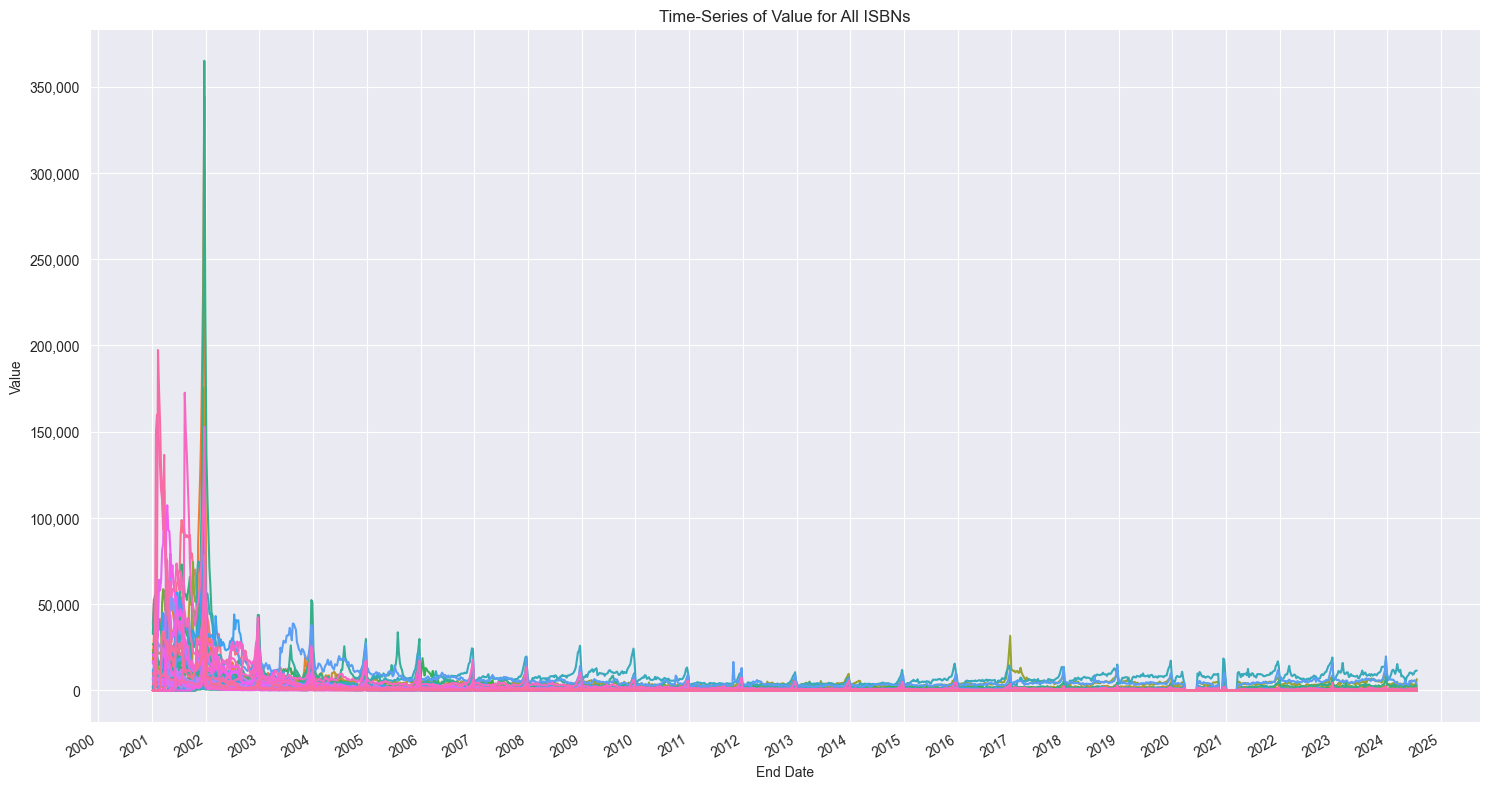

In [17]:
# Ensure 'End Date' is in datetime format
recent_sales_data['End Date'] = pd.to_datetime(recent_sales_data['End Date'])

# Sort the data by 'End Date'
recent_sales_data = recent_sales_data.sort_values(by='End Date')

# Get the list of unique ISBNs
unique_isbns = recent_sales_data['ISBN'].unique()

# Set the plotting style using seaborn
sns.set_style('darkgrid')

# Create a color palette
palette = sns.color_palette('husl', n_colors=len(unique_isbns))

# Create the figure and axis
plt.figure(figsize=(15, 8))

# Loop over each ISBN and plot on the same axes
for i, isbn in enumerate(unique_isbns):
    isbn_data = recent_sales_data[recent_sales_data['ISBN'] == isbn]
    plt.plot(isbn_data['End Date'], isbn_data['Value'], color=palette[i])

# Formatting the plot
plt.title('Time-Series of Value for All ISBNs')
plt.xlabel('End Date')
plt.ylabel('Value')
plt.grid(True)

# Format the y-axis labels with commas
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

# Adjust x-axis date spacing to show once a year
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

There are four distinct conclusions we can draw from the graph above:
* The most visible pattern is the very chaotic first 11 years of sales data, where weekly volumes are drastically higher and with far greater volatility. This could be caused either by poor data gathering, or the book's release to the public increasing demand. Either way, the figure shows generally decreasing demand for the first 11 years.
* After the 2012 period, the trend of Value increases slowly again. This could be due to inflationary effects on prices, or secular trends in the purchase of books generating greater sales volume.
* For many books, Value has a seasonal component around the end of each year (coinciding with the festive period).
* The pandemic closures of 2020-2022 are clearly visible, and may affect forecasting accuracy. 

#### The Alchemist and The Very Hungry Caterpillar

We will now analyse two books in greater detail 

In [18]:
# Define the list of ISBNs to include (The Very Hungry Caterpillar has two ISBNs)
book_isbns = ['9780140500875', '9780241003008', '9780722532935']

# Filter the DataFrame to include only the selected ISBNs
two_books_sales_data = total_sales_data[total_sales_data['ISBN'].isin(book_isbns)].copy()

# Filter the DataFrame in place to include only rows where 'End Date' is after 01/01/2012
two_books_sales_data = two_books_sales_data[two_books_sales_data['End Date'] > pd.Timestamp('2012-01-01')]

# Modify the 'Title' column as specified
two_books_sales_data.loc[
    two_books_sales_data['Title'] == 'Very Hungry Caterpillar,The:The Very Hungry Caterpillar',
    'Title'
] = 'Very Hungry Caterpillar,The'

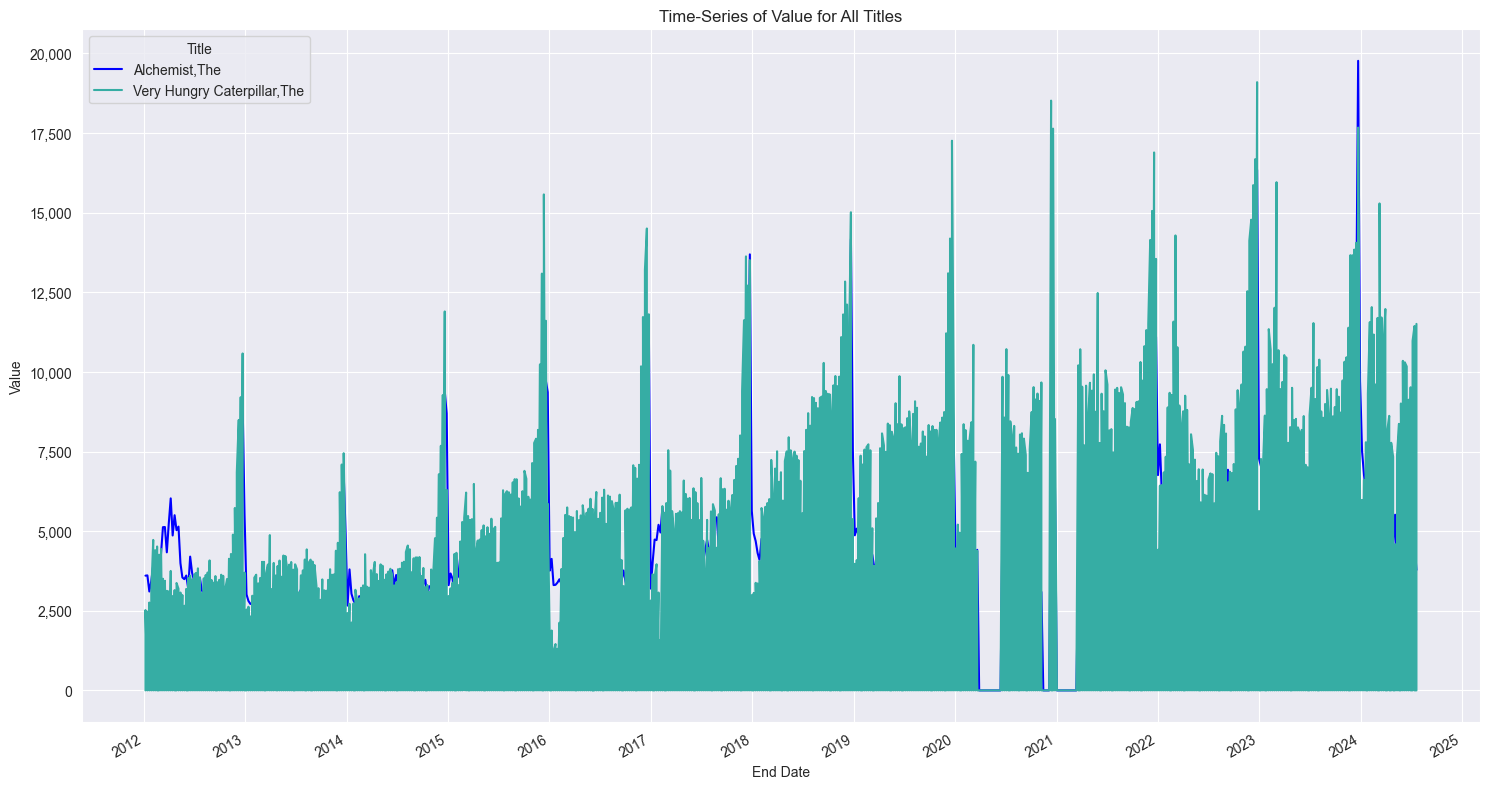

In [19]:
# Ensure 'End Date' is in datetime format
two_books_sales_data['End Date'] = pd.to_datetime(two_books_sales_data['End Date'])

# Sort the data by 'End Date'
two_books_sales_data = two_books_sales_data.sort_values(by='End Date')

# Get the list of unique Titles
unique_titles = two_books_sales_data['Title'].unique()

# Set the plotting style using seaborn
sns.set_style('darkgrid')

# Create a color palette
palette = sns.color_palette('husl', n_colors=len(unique_titles))

# Create the figure and axis
plt.figure(figsize=(15, 8))

# Loop over each title and plot on the same axes
for i, title in enumerate(unique_titles):
    title_data = two_books_sales_data[two_books_sales_data['Title'] == title]
    
    # Set one of the titles to blue, and the rest will use the palette
    if i == 0:  # Adjust index to choose which line will be blue
        plt.plot(title_data['End Date'], title_data['Value'], color='blue', label=title)
    else:
        plt.plot(title_data['End Date'], title_data['Value'], color=palette[i], label=title)

# Formatting the plot
plt.title('Time-Series of Value for All Titles')
plt.xlabel('End Date')
plt.ylabel('Value')
plt.grid(True)

# Format the y-axis labels with commas
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

# Adjust x-axis date spacing to show once a year
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

# Show the legend
plt.legend(title='Title', loc='best')

plt.tight_layout()
plt.show()

The pandemic lockdowns will have a very large impact on any analysis, adding noise. We will therefore interpolate these values using a Piecewise Cubic Hermite Interpolating Polynomial (PCHIP) Interpolator, as using a cubic or quadratic spline leads to values below zero. These values below zero are caused the large gap in data, which can lead to oscillations in the spline. PCHIP may create data which is smoother than regular data, however this is a lesser evil compared to incorporating the impact of the pandemic in any forecasts.  

Processing Alchemist,The...
No duplicate dates found for Alchemist,The.
Number of missing values for Alchemist,The after aggregation: 27
Number of valid data points for Alchemist,The: 628


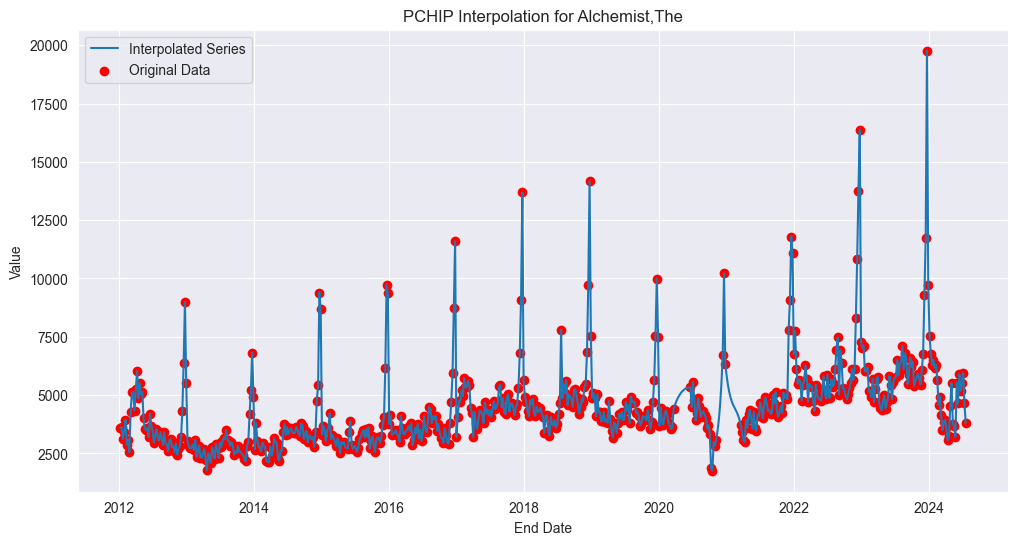

Processing Very Hungry Caterpillar,The...
Duplicate dates found for Very Hungry Caterpillar,The. Aggregating duplicates.
Number of missing values for Very Hungry Caterpillar,The after aggregation: 27
Number of valid data points for Very Hungry Caterpillar,The: 628


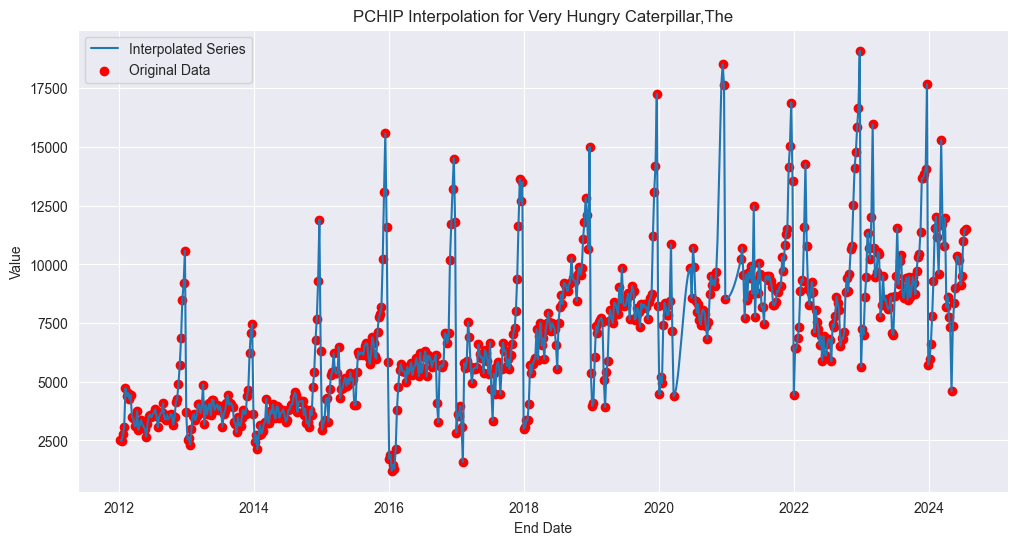

In [20]:
# Sort the data by 'End Date'
two_books_sales_data.sort_values('End Date', inplace=True)

# Get the list of titles to analyze
titles_to_analyze = two_books_sales_data['Title'].unique()

# Loop through each title
for title in titles_to_analyze:
    print(f"Processing {title}...")
    
    # Filter data for the current title
    title_data = two_books_sales_data[two_books_sales_data['Title'] == title].copy()
    
    # Set 'End Date' as the index and normalize
    title_data.set_index('End Date', inplace=True)
    title_data.index = title_data.index.normalize()
    title_data.index = title_data.index.tz_localize(None)
    title_data.sort_index(inplace=True)
    
    # Replace zeros with NaN during pandemic closures
    pandemic_start = pd.to_datetime('2020-03-01')
    pandemic_end = pd.to_datetime('2021-06-30')
    title_data.loc[
        (title_data.index >= pandemic_start) & 
        (title_data.index <= pandemic_end) & 
        (title_data['Value'] == 0), 
        'Value'
    ] = np.nan
    
    # Handle duplicate dates
    if title_data.index.duplicated().any():
        print(f"Duplicate dates found for {title}. Aggregating duplicates.")
        title_data = title_data.groupby(title_data.index).agg({
            'Value': lambda x: x.sum(min_count=1),
            # Handle other columns as needed
        })
    else:
        print(f"No duplicate dates found for {title}.")
    
    # Verify that there are no duplicates
    if title_data.index.duplicated().any():
        raise ValueError(f"Duplicates still exist in the index for {title}!")
    
    # Count missing values after aggregation
    missing_values_after_agg = title_data['Value'].isnull().sum()
    print(f"Number of missing values for {title} after aggregation: {missing_values_after_agg}")
    
    # Reindex to include all weekly dates
    full_range = pd.date_range(start=title_data.index.min(), end=title_data.index.max(), freq='W-SAT')
    title_data = title_data.reindex(full_range)
    
    # Extract the 'Value' column
    ts = title_data['Value']
    
    # Identify valid and missing data
    valid = ts[ts.notnull()]
    missing = ts[ts.isnull()]
    
    # Check if there are at least 3 valid data points
    num_valid_points = len(valid)
    print(f"Number of valid data points for {title}: {num_valid_points}")
    
    if not missing.empty and num_valid_points >= 3:
        # Convert dates to ordinal numbers
        x_valid = valid.index.map(pd.Timestamp.toordinal)
        y_valid = valid.values
        x_missing = missing.index.map(pd.Timestamp.toordinal)
        
        # Apply PCHIP interpolation
        interpolator = PchipInterpolator(x_valid, y_valid)
        y_missing = interpolator(x_missing)
        
        # Update the missing values in the time series
        ts.loc[ts.isnull()] = y_missing
        
        # Update the 'Value' column in title_data
        title_data['Value'] = ts
        
        # Reset the index
        title_data.reset_index(inplace=True)
        title_data.rename(columns={'index': 'End Date'}, inplace=True)
        
        # Add 'Title' column back if necessary
        title_data['Title'] = title
        
        # Ensure 'End Date' is in datetime format
        title_data['End Date'] = pd.to_datetime(title_data['End Date'])
        
        # Merge the interpolated data back into the main DataFrame
        two_books_sales_data = pd.merge(
            two_books_sales_data,
            title_data[['End Date', 'Title', 'Value']],
            on=['End Date', 'Title'],
            how='left',
            suffixes=('', '_interp')
        )
        
        # Update 'Value' column with interpolated values where they exist
        two_books_sales_data['Value'] = two_books_sales_data['Value_interp'].combine_first(two_books_sales_data['Value'])
        
        # Drop the 'Value_interp' column
        two_books_sales_data.drop(columns=['Value_interp'], inplace=True)
        
        # Plot the results for validation
        plt.figure(figsize=(12, 6))
        plt.plot(title_data['End Date'], title_data['Value'], label='Interpolated Series')
        plt.scatter(valid.index, y_valid, color='red', label='Original Data')
        plt.title(f'PCHIP Interpolation for {title}')
        plt.xlabel('End Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()
    elif num_valid_points < 3 and not missing.empty:
        print(f"Insufficient valid data points for interpolation for {title}.")
        # Consider using linear interpolation instead
        ts.interpolate(method='linear', inplace=True)
        title_data['Value'] = ts
        title_data.reset_index(inplace=True)
        title_data.rename(columns={'index': 'End Date'}, inplace=True)
        title_data['Title'] = title
        title_data['End Date'] = pd.to_datetime(title_data['End Date'])
        
        # Merge the interpolated data back into the main DataFrame
        two_books_sales_data = pd.merge(
            two_books_sales_data,
            title_data[['End Date', 'Title', 'Value']],
            on=['End Date', 'Title'],
            how='left',
            suffixes=('', '_interp')
        )
        
        # Update 'Value' column with interpolated values where they exist
        two_books_sales_data['Value'] = two_books_sales_data['Value_interp'].combine_first(two_books_sales_data['Value'])
        
        # Drop the 'Value_interp' column
        two_books_sales_data.drop(columns=['Value_interp'], inplace=True)
        
        # Plot the results for validation
        plt.figure(figsize=(12, 6))
        plt.plot(title_data['End Date'], title_data['Value'], label='Linearly Interpolated Series')
        plt.scatter(valid.index, y_valid, color='red', label='Original Data')
        plt.title(f'Linear Interpolation for {title}')
        plt.xlabel('End Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()
    else:
        print(f"No missing values to interpolate for {title}.")

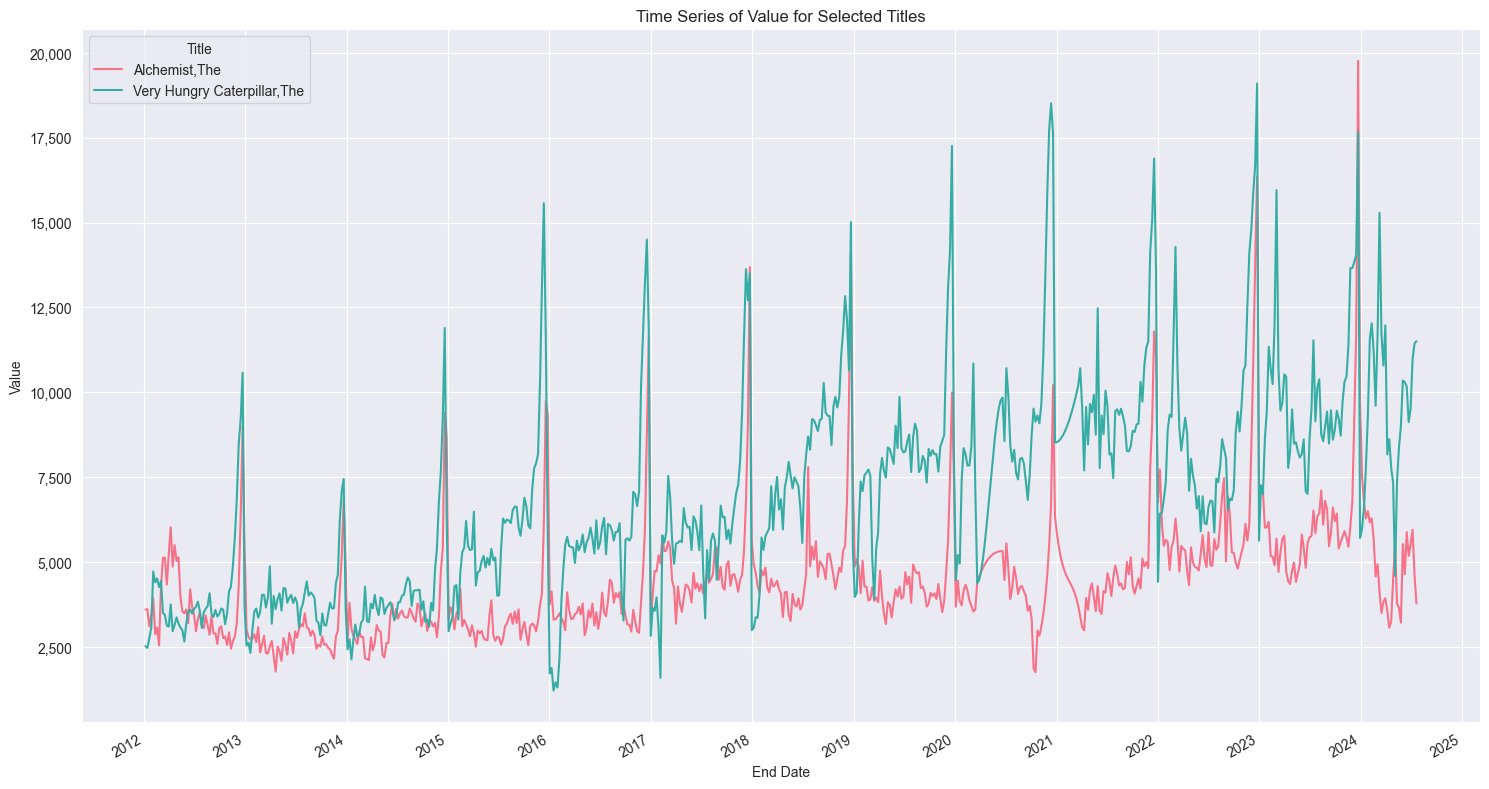

In [21]:
# Set the plotting style using seaborn
sns.set_style('darkgrid')

# Create a color palette
palette = sns.color_palette('husl', n_colors=len(unique_titles))

# Create the figure and axis
plt.figure(figsize=(15, 8))

# Loop over each title and plot on the same axes
for i, title in enumerate(unique_titles):
    title_data = two_books_sales_data[two_books_sales_data['Title'] == title]
    
    # Plot each title with a distinct color
    plt.plot(title_data['End Date'], title_data['Value'], color=palette[i], label=title)

# Formatting the plot
plt.title('Time Series of Value for Selected Titles')
plt.xlabel('End Date')
plt.ylabel('Value')
plt.grid(True)

# Format the y-axis labels with commas
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

# Adjust x-axis date spacing to show once a year
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

# Show the legend
plt.legend(title='Title', loc='best')

plt.tight_layout()
plt.show()

In [22]:
# Save two_books_sales_data to a csv file
two_books_sales_data.to_csv('two_books_sales_data.csv', index=False)

In [2]:
# Load two_books_sales_data, skipping all data processing steps
two_books_sales_data = pd.read_csv('two_books_sales_data.csv')

two_books_sales_data['End Date'] = pd.to_datetime(two_books_sales_data['End Date'])

two_books_sales_data

,ISBN,End Date,Title,Author,Interval,Volume,Value,ASP,RRP,Binding,Imprint,Publisher Group,Product Class,Product Category,Publication Date,Country of Publication
0,9780722532935,2012-01-07,"Alchemist,The","Coelho, Paulo",201202,518.0,3601.76,6.9532,9.99,Paperback,Thorsons,HarperCollins Grp,F1.1 General & Literary Fiction,F - Adult Fiction,1995-11-13,United Kingdom
1,9780140500875,2012-01-07,"Very Hungry Caterpillar,The","Carle, Eric",201202,0.0,2522.13,0.0000,4.99,Paperback,Puffin Books,Penguin Grp,Y1.3 Picture Books,"Y Children's, YA & Educational",1974-03-28,United Kingdom
2,9780241003008,2012-01-07,"Very Hungry Caterpillar,The","Carle, Eric",201202,512.0,2522.13,4.9260,7.99,Hardback,Puffin Books,Penguin Grp,Y1.3 Picture Books,"Y Children's, YA & Educational",1994-09-29,United Kingdom
3,9780722532935,2012-01-14,"Alchemist,The","Coelho, Paulo",201203,533.0,3610.12,6.7732,9.99,Paperback,Thorsons,HarperCollins Grp,F1.1 General & Literary Fiction,F - Adult Fiction,1995-11-13,United Kingdom
4,9780140500875,2012-01-14,"Very Hungry Caterpillar,The","Carle, Eric",201203,0.0,2473.31,0.0000,4.99,Paperback,Puffin Books,Penguin Grp,Y1.3 Picture Books,"Y Children's, YA & Educational",1974-03-28,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960,9780241003008,2024-07-13,"Very Hungry Caterpillar,The","Carle, Eric",202428,2482.0,11441.03,4.6096,7.99,Hardback,Puffin Books,Penguin Grp,Y1.3 Picture Books,"Y Children's, YA & Educational",1994-09-29,United Kingdom
1961,9780722532935,2024-07-13,"Alchemist,The","Coelho, Paulo",202428,510.0,4638.63,9.0954,9.99,Paperback,Thorsons,HarperCollins Grp,F1.1 General & Literary Fiction,F - Adult Fiction,1995-11-13,United Kingdom
1962,9780140500875,2024-07-20,"Very Hungry Caterpillar,The","Carle, Eric",202429,0.0,11507.46,0.0000,4.99,Paperback,Puffin Books,Penguin Grp,Y1.3 Picture Books,"Y Children's, YA & Educational",1974-03-28,United Kingdom
1963,9780722532935,2024-07-20,"Alchemist,The","Coelho, Paulo",202429,408.0,3782.61,9.2711,9.99,Paperback,Thorsons,HarperCollins Grp,F1.1 General & Literary Fiction,F - Adult Fiction,1995-11-13,United Kingdom


Not much can be gleaned from just looking at the time series of the Value column, therefore we will conduct decomposition on them individually.

#### Decomposition

There are several decomposition techniques available to us:
* Classical decomposition, where additive decomposition can be used when the trend + seasonality does not change over time. multiplicative decomposition can be used when the trend + seasonality increases gradually over time.
* Seasonal-Trend-Loss (STL), which uses Locally Estimated Scatterplot Smoothing (LOESS), which allows for changing trend/seasonality over time.
* X-11 and X-12 ARIMA, which are mainly used on economic data to identify cycles by precisely filtering out seasonality
* Unobserved Components Model (UCM), which adds a cycle component to the trend-seasonality-residual outputs.

The sales data of each book is not cyclical, excluding the X-11, X-12 and UCM models. The cyclical component does not regularly increase or decrease, excluding the classical multiplicative model. Finally the trend component changes over time, indicating STL will be the most suitable model to decompose the time series in question.

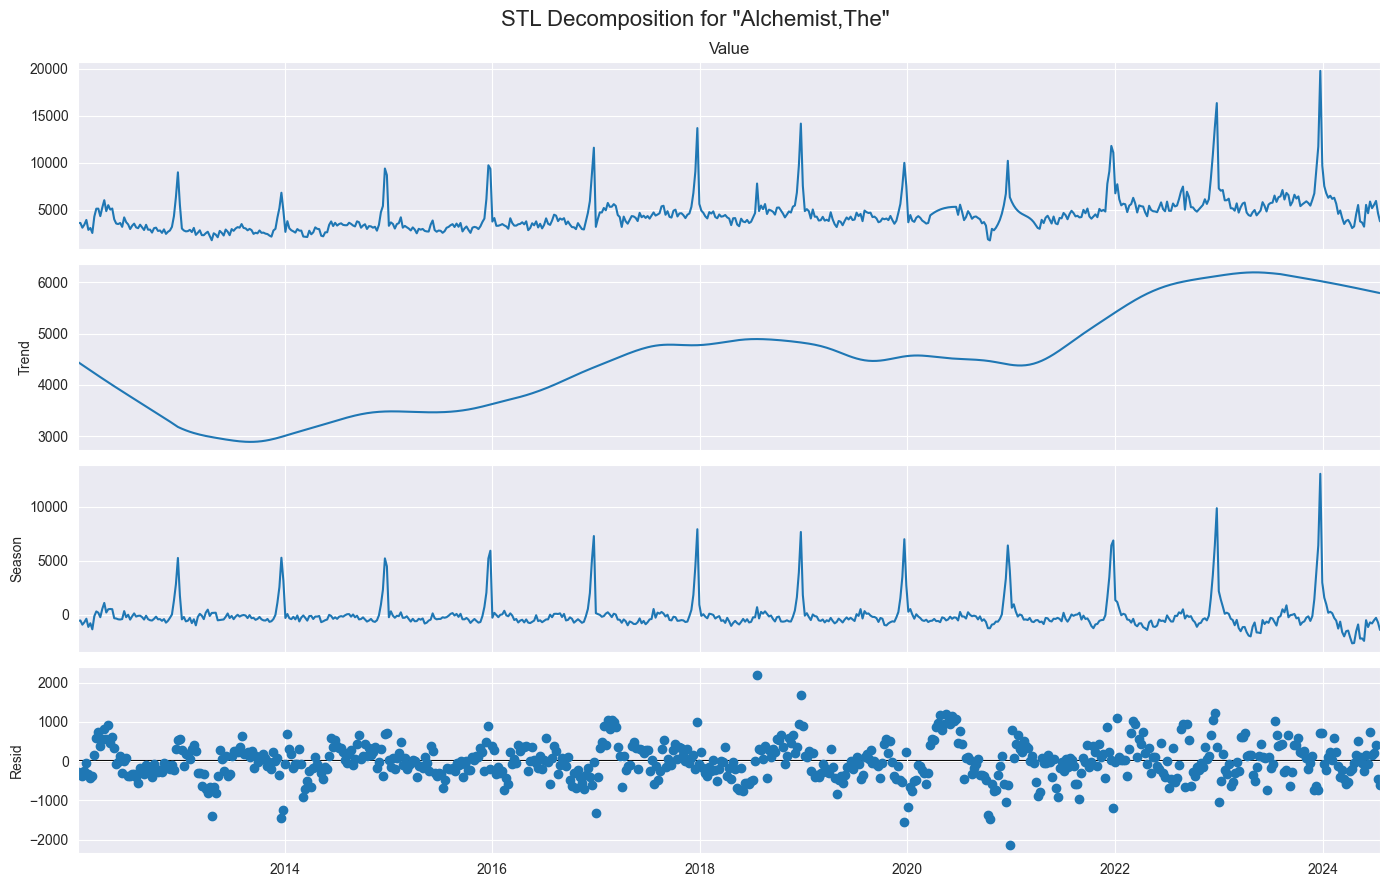

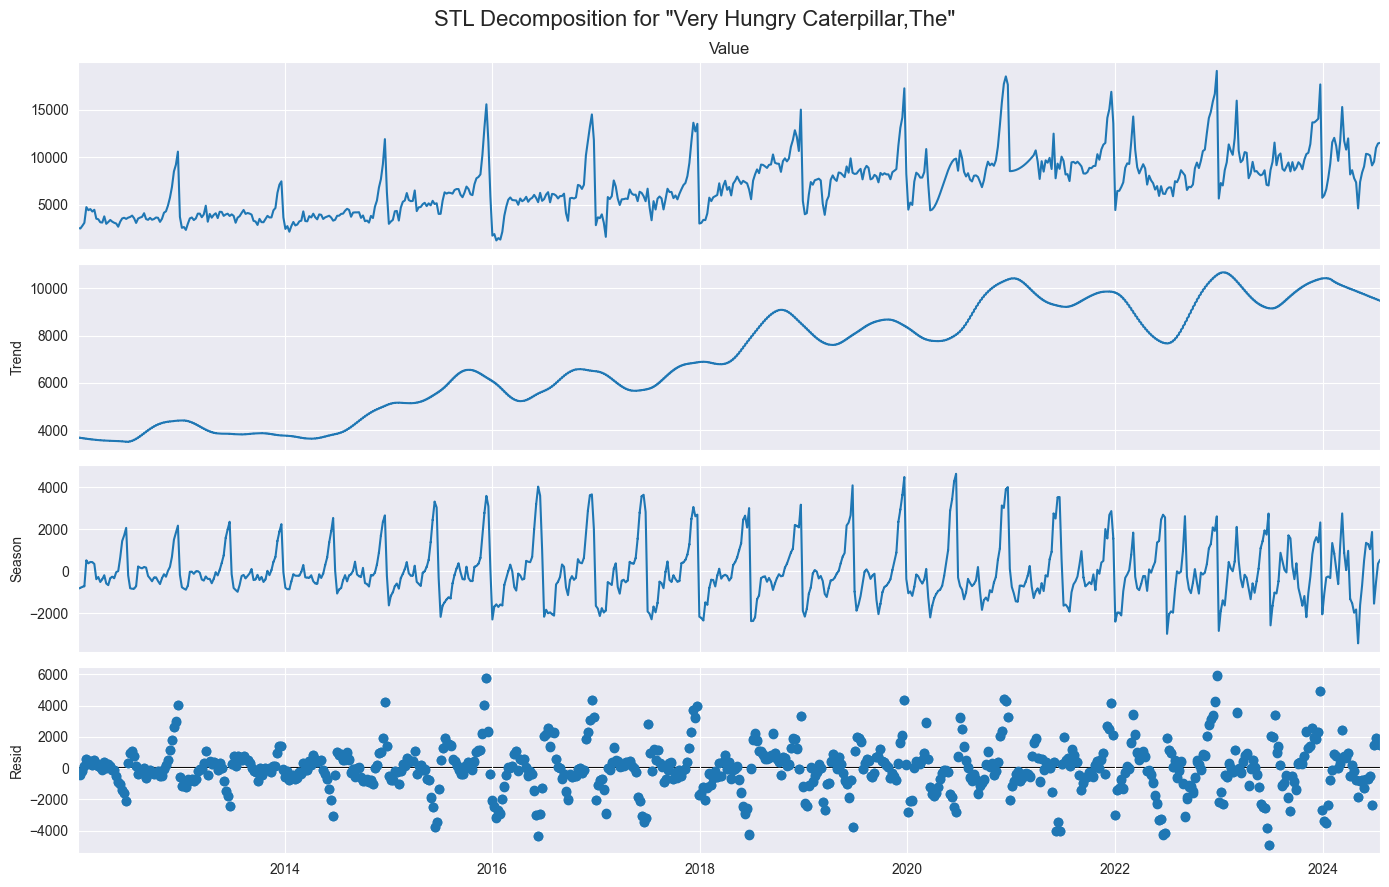

In [168]:
# Filter relevant columns: 'End Date', 'Title', and 'Value'
filtered_data = two_books_sales_data[['End Date', 'Title', 'Value']]

# Define the titles to analyze
titles_to_analyze = filtered_data['Title'].unique()


# Loop through each title and perform STL decomposition
for title in titles_to_analyze:
    # Filter the data for the current title
    title_data = filtered_data[filtered_data['Title'] == title].copy()
    
    # Set 'End Date' as the index and sort it
    title_data.set_index('End Date', inplace=True)
    title_data.sort_index(inplace=True)
    
    # Extract the 'Value' column
    ts = title_data['Value']
    
    # Perform STL decomposition
    stl = STL(ts, period=52)
    stl_result = stl.fit()
    
    # Plot the decomposition
    fig = stl_result.plot()
    fig.set_size_inches(14, 9)
    fig.suptitle(f'STL Decomposition for "{title}"', fontsize=16)
    plt.tight_layout()
    plt.show()

The Alchemist has a generally increasing trend, peaking well after the negative impact of pandemic lockdowns. Seasonality is very constant, indicating the book tends to be bought just before the end of the year around the Christmas period. The residual is relatively constant, perhaps stationary.

The Very Hungry Caterpillar also has a generally increasing trend, with more volatility. This could indicate STL is not decomposing the entirety of the seasonal/residual components. The seasonality is also more volatile than The Alchemist's, with volatility of the seasonality increasing and decreasing over time. The residual increases over time, and is therefore likely not stationary.

#### ACF and PACF

Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) are useful tools to identify the appropriate structure of ARIMA models. ACF helps visualise the relationship of a datapoint with its previous datapoints, and a quickly decaying ACF indicates stationarity. PACF does the same, only isolating the direct correlation at a specific lag.


Processing Alchemist,The...
ADF Statistic: -9.173605
p-value: 0.000000
The time series for Alchemist,The is stationary.


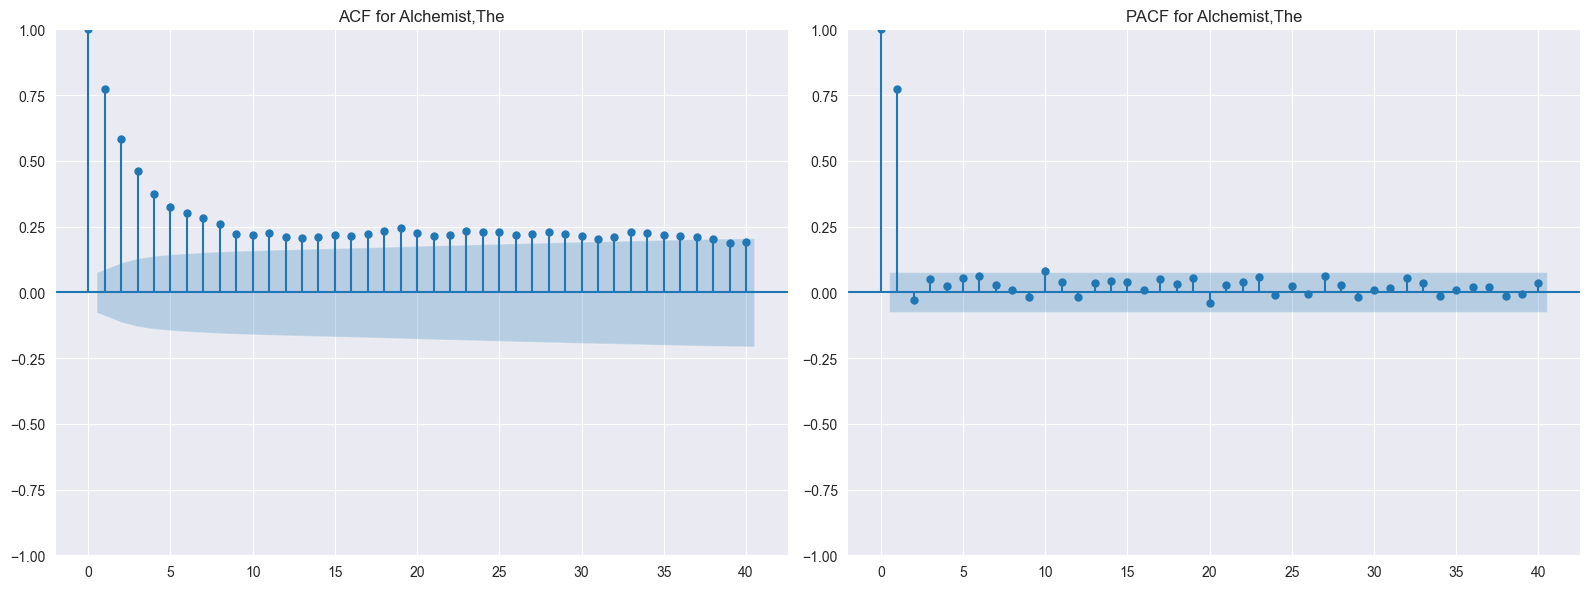


Processing Very Hungry Caterpillar,The...
ADF Statistic: -3.251196
p-value: 0.017206
The time series for Very Hungry Caterpillar,The is stationary.


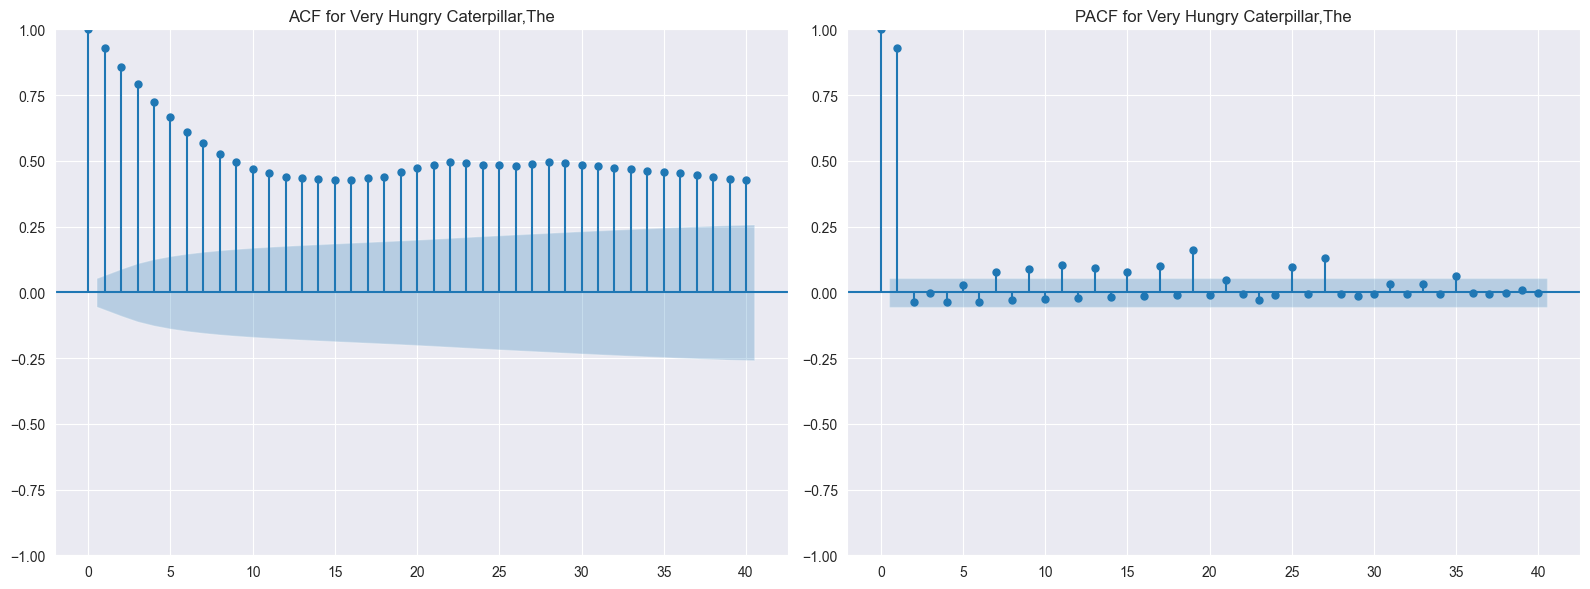

In [147]:
for title in titles_to_analyze:
    print(f"\nProcessing {title}...")
    
    # Filter data for the current title
    title_data = two_books_sales_data[two_books_sales_data['Title'] == title].copy()
    
    # Set 'End Date' as the index
    title_data.set_index('End Date', inplace=True)
    
    # Ensure the index is sorted
    title_data.sort_index(inplace=True)
    
    # Extract the 'Value' series
    ts = title_data['Value']
    
    # Check for stationarity
    result = adfuller(ts)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    
    if result[1] > 0.05:
        print(f"The time series for {title} is non-stationary. Applying first-order differencing...")
        # Apply first-order differencing
        ts_diff = ts.diff().dropna()
        
        # Re-run the stationarity test
        result_diff = adfuller(ts_diff)
        print('ADF Statistic after differencing: %f' % result_diff[0])
        print('p-value after differencing: %f' % result_diff[1])
        if result_diff[1] > 0.05:
            print(f"The differenced series for {title} is still non-stationary. Consider higher-order differencing or other transformations.")
            data_to_plot = ts_diff
        else:
            print(f"The differenced series for {title} is stationary.")
            data_to_plot = ts_diff
    else:
        print(f"The time series for {title} is stationary.")
        data_to_plot = ts
    
    # Plot ACF and PACF
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    plot_acf(data_to_plot, ax=axes[0], lags=40)
    axes[0].set_title(f'ACF for {title}')
    
    plot_pacf(data_to_plot, ax=axes[1], lags=40, method='ywm')
    axes[1].set_title(f'PACF for {title}')
    
    plt.tight_layout()
    plt.show()

From the above we can conclude the following:
* Both datasets are stationary, therefore we can use ARIMA and other models without expecting poor forecasting performance due to the data's structure.
* The ACF of both books show significant autocorrelation, as would be expected from a series with a trend
* The PACF of The Alchemist indicates that an observation has a very high correlation to the last two observations, and a correlation to the 11th week before. In contrast, the PACF of The Very Hungry Caterpillar indicates stronger seasonality as it is correlated to not only the previous two observations, but also the 8th, 10th, 12th, 14th, 16th, 18th, 20th, 26th and 28th past observations.

#### Auto ARIMA

Auto ARIMA is a powerful tool for time series analysis that automates the process of selecting the optimal parameters for an ARIMA model. It searches over a specified set of ARIMA models and selects the best one according to a chosen information criterion. Once found, we will use this model to forecast the last 32 weeks of data. 

In [161]:
# Ensure 'End Date' is in datetime format
two_books_sales_data['End Date'] = pd.to_datetime(two_books_sales_data['End Date'])

# Sort the data by 'End Date'
two_books_sales_data.sort_values('End Date', inplace=True)

# List of titles to process
titles = ["Alchemist,The", "Very Hungry Caterpillar,The"]


Processing Alchemist,The...
Training set length for Alchemist,The: 623
Test set length for Alchemist,The: 32
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[52] intercept   : AIC=10088.251, Time=6.26 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=11025.351, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=inf, Time=17.72 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=4.07 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=12302.796, Time=0.03 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=10189.777, Time=4.12 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=9986.774, Time=17.31 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=10448.037, Time=0.07 sec
 ARIMA(1,0,1)(2,0,0)[52] intercept   : AIC=9993.932, Time=99.28 sec
 ARIMA(1,0,1)(2,0,1)[52] intercept   : AIC=inf, Time=119.02 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=10210.773, Time=7.55 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=inf, Time=16.18 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=10070.15

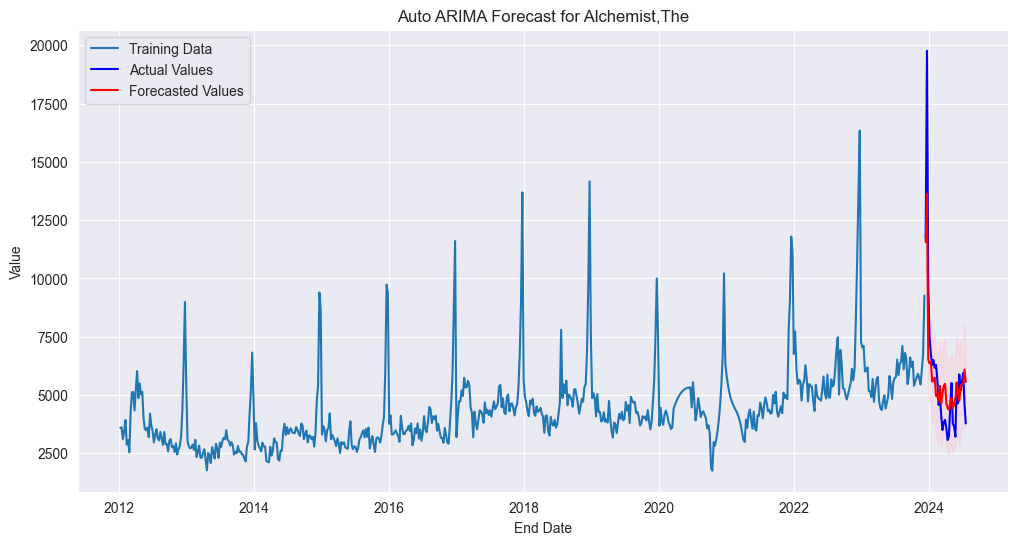

MAE for Alchemist,The: 1066.60762465773
RMSE for Alchemist,The: 1548.2452813569926

Processing Very Hungry Caterpillar,The...
Training set length for Very Hungry Caterpillar,The: 1246
Test set length for Very Hungry Caterpillar,The: 32
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[52] intercept   : AIC=20945.598, Time=9.50 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=23536.416, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=20976.614, Time=9.47 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=22264.880, Time=14.02 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=25789.192, Time=0.01 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=20977.263, Time=3.73 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=20977.231, Time=14.21 sec
 ARIMA(1,0,1)(2,0,1)[52] intercept   : AIC=20434.164, Time=195.09 sec
 ARIMA(1,0,1)(2,0,0)[52] intercept   : AIC=20432.323, Time=164.88 sec
 ARIMA(1,0,1)(3,0,0)[52] intercept   : AIC=20433.903, Time=237.39 sec
 ARIMA(1,0,1)(3,0,1)[52] intercep

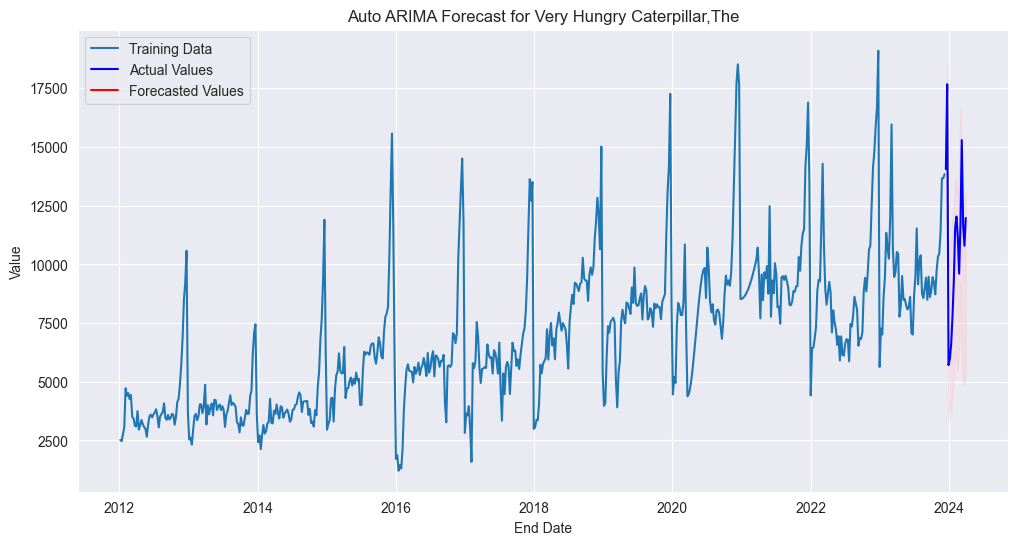

MAE for Very Hungry Caterpillar,The: 1760.5926053682979
RMSE for Very Hungry Caterpillar,The: 2222.4854986671526


In [162]:
for title in titles:
    print(f"\nProcessing {title}...")

    # Filter data for the current title
    title_data = two_books_sales_data[two_books_sales_data['Title'] == title].copy()

    # Check if data is available for the title
    if title_data.empty:
        print(f"No data available for {title}. Skipping to next title.")
        continue

    # Set 'End Date' as the index
    title_data.set_index('End Date', inplace=True)

    # Ensure the index is sorted
    title_data.sort_index(inplace=True)

    # Extract the 'Value' series
    ts = title_data['Value']

    # Define the split date
    split_date = pd.to_datetime('2023-12-16')

    # Check if the split date exists in the index
    if split_date not in ts.index:
        print(f"Split date {split_date.date()} not found in the data index for {title}.")
        # Adjust split date as necessary
        future_dates = ts.index[ts.index >= split_date]
        if len(future_dates) > 0:
            split_date = future_dates[0]
            print(f"Adjusted split date to next available date: {split_date.date()}")
        else:
            # If no future dates, adjust to get the last 32 observations
            if len(ts) >= 32:
                split_date = ts.index[-32]
                print(f"Adjusted split date to last 32 observations starting from: {split_date.date()}")
            else:
                print(f"Not enough data to create a test set of 32 observations for {title}.")
                split_date = ts.index[-1]
                test = pd.Series(dtype=float)

    # Split the data into training and testing sets
    train = ts.loc[:split_date - pd.Timedelta(seconds=1)]
    test = ts.loc[split_date:]

    # Ensure the test set has 32 observations
    if len(test) < 32:
        print(f"Warning: The test set for {title} has only {len(test)} observations instead of 32.")
        if len(ts) >= 32:
            # Adjust to use the last 32 observations
            test = ts.iloc[-32:]
            train = ts.iloc[:-32]
            print(f"Adjusted the training and test sets to have the last 32 observations as the test set.")
        else:
            print(f"Not enough data to create a test set of 32 observations for {title}.")
            train = ts
            test = pd.Series(dtype=float)
    elif len(test) > 32:
        # Use only the first 32 observations of the test set
        test = test.iloc[:32]

    print(f"Training set length for {title}: {len(train)}")
    print(f"Test set length for {title}: {len(test)}")

    # Fit Auto ARIMA model on the training data
    model = auto_arima(
        train,
        start_p=1,
        max_p=3,
        start_q=1,
        max_q=3,
        start_P=1,
        max_P=3,
        start_Q=1,
        max_Q=3,
        max_order=5,
        m=52,
        seasonal=True,
        test='adf',
        trace=False,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True,
        information_criterion='aic',
        alpha=0.05,
        n_jobs=-1,
        maxiter=50
    )

    # Print the model summary
    print(model.summary())

    if not test.empty:
        # Forecast future values
        n_periods = len(test)
        forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

        # Create a DataFrame for the forecast
        forecast_index = test.index
        forecast_series = pd.Series(forecast, index=forecast_index)
        conf_int_df = pd.DataFrame(conf_int, index=forecast_index, columns=['Lower', 'Upper'])

        # Plot the forecast
        plt.figure(figsize=(12, 6))
        plt.plot(train.index, train, label='Training Data')
        plt.plot(test.index, test, label='Actual Values', color='blue')
        plt.plot(forecast_index, forecast_series, label='Forecasted Values', color='red')
        plt.fill_between(forecast_index, conf_int_df['Lower'], conf_int_df['Upper'], color='pink', alpha=0.3)
        plt.title(f'Auto ARIMA Forecast for {title}')
        plt.xlabel('End Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

        # Evaluate the model
        mae = mean_absolute_error(test, forecast)
        mse = mean_squared_error(test, forecast)
        rmse = np.sqrt(mse)
        print(f'MAE for {title}: {mae}')
        print(f'RMSE for {title}: {rmse}')
    else:
        print(f"No test data available for {title}. Model fitted on the entire dataset.")

The best model for The Alchemist is ARIMA(1,0,1)(1,0,0), a simpler model than the best fit for The Very Hungry Caterpillar with ARIMA(2,0,1)(2,0,0). In line with their respective ACF and PACF findings, the second book has a greater reliance on lags further away from the observation being predicted, both for the trend and seasonal elements.

The MAE and RMSE of The Very Hungry Caterpillar are larger than those of The Alchemist, which is to be expected given the greater volatility in sales Value and larger residuals exhibited by that book's decomposition. Broadly, these factors make it more difficult to predict the time series, leading to greater residuals.

Visualising the forecasts on the last 32 weeks of data (the end of 2023 and 2024 to July) we can identify that the ARIMA model has under-estimated the scale of movement in sales, but has correctly predicted the shape sales took during this period. The Very Hungry Caterpillar did not get a line predicting its sales, but its confidence intervals indicate it has more trouble forecasting sales.

#### GXBoost


First, we define several helper functions: prepare_data to generate lags and split the data into train/test sets, train_and_tune_model to train the model, and custom_grid_search to allow us to change the number of lags in the grid search (as GridSearchCV does not include this functionality)

In [3]:
def prepare_data(df, title, lag_steps, forecast_weeks=32):
    """
    Prepares the data for a specific book title and lag_steps.

    Parameters:
    - df: The entire DataFrame containing the data.
    - title: The book title to filter data.
    - lag_steps: Number of lag features to create.
    - forecast_weeks: Number of weeks to use as the test set.

    Returns:
    - X_train, X_test, y_train, y_test
    """
    # Filter data for the given title
    df_title = df[df['Title'] == title].copy()

    # Check if data is available
    if df_title.empty:
        print(f"No data available for {title}.")
        return None, None, None, None

    # Sort data by 'End Date'
    df_title.sort_values('End Date', inplace=True)

    # Reset index
    df_title.reset_index(drop=True, inplace=True)

    # Create lag features
    for lag in range(1, lag_steps + 1):
        df_title[f'lag_{lag}'] = df_title['Value'].shift(lag)

    # Drop rows with NaN values
    df_title.dropna(inplace=True)

    # Ensure we have enough data
    total_observations = len(df_title)
    if total_observations <= forecast_weeks:
        print(f"Not enough data to create training and test sets for {title} with lag_steps={lag_steps}.")
        return None, None, None, None

    # Split the data
    train_data = df_title.iloc[:-forecast_weeks]
    test_data = df_title.iloc[-forecast_weeks:]

    # Define feature columns
    feature_columns = [col for col in df_title.columns if col.startswith('lag_')]

    # Separate features and target
    X_train = train_data[feature_columns]
    y_train = train_data['Value']
    X_test = test_data[feature_columns]
    y_test = test_data['Value']

    return X_train, X_test, y_train, y_test

In [4]:
def train_and_tune_model(X_train, y_train, X_test, y_test, param_distributions):
    from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    # Initialize XGBoost regressor
    xgb_reg = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42
    )

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=xgb_reg,
        param_distributions=param_distributions,
        n_iter=50,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    # Fit RandomizedSearchCV
    random_search.fit(X_train, y_train)

    # Best model
    best_model = random_search.best_estimator_

    # Predict on test set
    y_pred = best_model.predict(X_test)

    # Evaluate the model using sklearn's built-in functions
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Handle zero values in y_test for MAPE calculation
    non_zero_indices = y_test != 0
    if np.any(non_zero_indices):
        y_test_non_zero = y_test[non_zero_indices]
        y_pred_non_zero = y_pred[non_zero_indices]
        mape = mean_absolute_percentage_error(y_test_non_zero, y_pred_non_zero) * 100
    else:
        mape = np.inf  # or assign a large number

    evaluation_metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Best Parameters': random_search.best_params_
    }

    return best_model, evaluation_metrics

In [5]:
def custom_grid_search(df, title, param_grid, forecast_weeks=32):
    """
    Performs custom search over lag_steps and model hyperparameters.

    Parameters:
    - df: The entire DataFrame.
    - title: The book title to process.
    - param_grid: Dictionary containing lists of hyperparameters to search, including 'lag_steps'.
    - forecast_weeks: Number of weeks to forecast.

    Returns:
    - best_model: The model with the best hyperparameters.
    - best_metrics: Evaluation metrics for the best model.
    - best_lag_steps: The optimal number of lag steps.
    """
    # Extract list of lag_steps to try
    lag_steps_list = param_grid['lag_steps']
    # Remove 'lag_steps' from param_grid to prevent errors in RandomizedSearchCV
    param_grid_model = param_grid.copy()
    del param_grid_model['lag_steps']

    best_score = np.inf
    best_model = None
    best_metrics = None
    best_lag_steps = None

    for lag_steps in lag_steps_list:
        print(f"\nTesting lag_steps = {lag_steps}")
        # Prepare data with current lag_steps
        X_train, X_test, y_train, y_test = prepare_data(df, title, lag_steps, forecast_weeks)

        # Check if data preparation was successful
        if X_train is None:
            continue

        # Train and tune model
        model, metrics = train_and_tune_model(X_train, y_train, X_test, y_test, param_grid_model)

        # Compare MAE to find the best model
        if metrics['MAE'] < best_score:
            best_score = metrics['MAE']
            best_model = model
            best_metrics = metrics
            best_lag_steps = lag_steps

    if best_model is not None:
        print(f"\nBest lag_steps: {best_lag_steps}")
        print(f"Best Parameters: {best_metrics['Best Parameters']}")
        print(f"Best MAE: {best_metrics['MAE']}")
        print(f"Best RMSE: {best_metrics['RMSE']}")
        print(f"Best MAPE: {best_metrics['MAPE']}%")
    else:
        print("No valid models were found.")

    return best_model, best_metrics, best_lag_steps

Then, we set the parameters and use these functions in a loop to generate the best models for each book

In [6]:
# Define the parameter grid
param_grid = {
    'lag_steps': [3, 6, 9], 
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.5, 0.8],
    'gamma': [0, 1, 2, 3],
    'reg_alpha': [0, 50, 100],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'min_child_weight': [1, 3, 5]
}



Processing Alchemist,The...

Testing lag_steps = 3
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Testing lag_steps = 6
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Testing lag_steps = 9
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best lag_steps: 6
Best Parameters: {'subsample': 0.8, 'reg_alpha': 50, 'n_estimators': 50, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 3, 'colsample_bytree': 0.9}
Best MAE: 1030.3886495971678
Best RMSE: 1858.5112763609047
Best MAPE: 17.008286644680656%


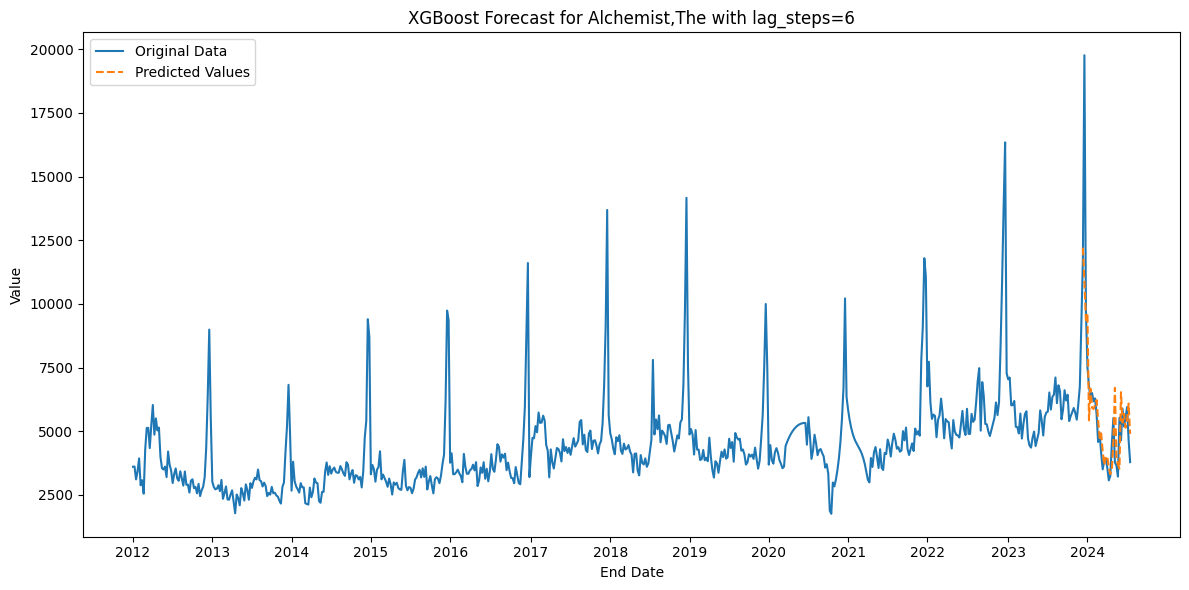


Processing Very Hungry Caterpillar,The...

Testing lag_steps = 3
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Testing lag_steps = 6
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Testing lag_steps = 9
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best lag_steps: 6
Best Parameters: {'subsample': 0.8, 'reg_alpha': 0, 'n_estimators': 50, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 2, 'colsample_bytree': 0.9}
Best MAE: 615.9957757568359
Best RMSE: 982.2481366350851
Best MAPE: 7.976264264221562%


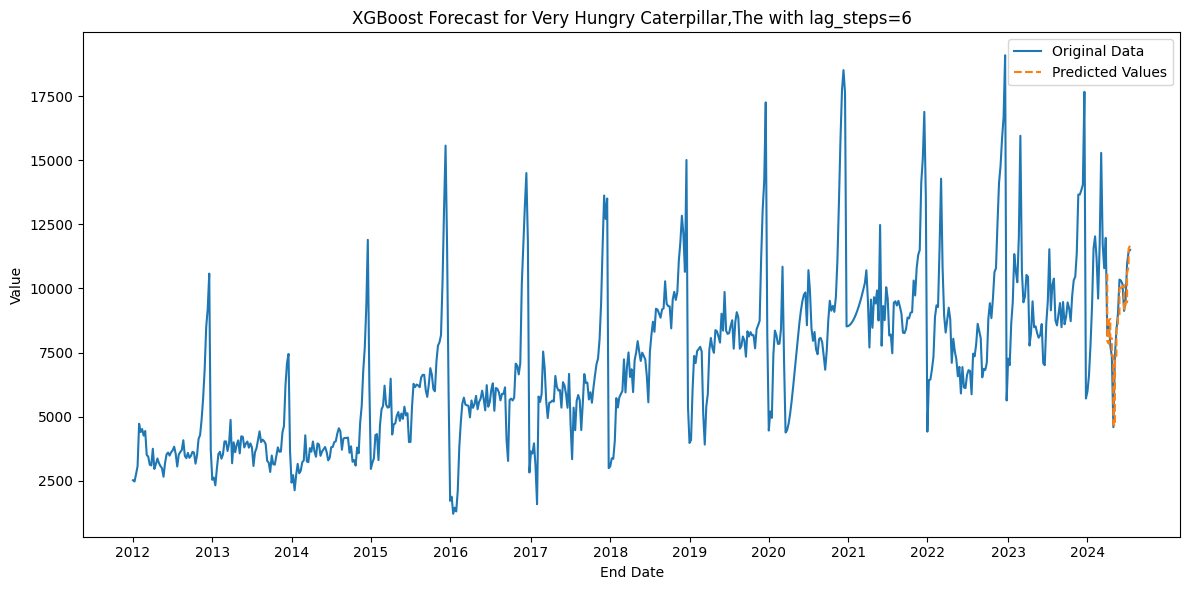

In [7]:
# Titles to process
titles = ["Alchemist,The", "Very Hungry Caterpillar,The"]

for title in titles:
    print(f"\nProcessing {title}...")
    best_model, best_metrics, best_lag_steps = custom_grid_search(two_books_sales_data, title, param_grid)

    if best_model is not None:
        # Prepare data with best lag_steps for plotting
        X_train, X_test, y_train, y_test = prepare_data(two_books_sales_data, title, best_lag_steps)

        # Get the original data for plotting
        df_title = two_books_sales_data[two_books_sales_data['Title'] == title].copy()
        df_title.sort_values('End Date', inplace=True)
        df_title.reset_index(drop=True, inplace=True)

        # Ensure 'End Date' is datetime
        df_title['End Date'] = pd.to_datetime(df_title['End Date'])

        # Predict on the test set
        y_pred = best_model.predict(X_test)

        # Plotting
        plt.figure(figsize=(12, 6))
        # Plot the original data without markers
        plt.plot(df_title['End Date'], df_title['Value'], label='Original Data', linestyle='-')
        # Plot the predictions without markers
        plt.plot(df_title['End Date'].iloc[y_test.index], y_pred, label='Predicted Values', linestyle='--')

        plt.title(f"XGBoost Forecast for {title} with lag_steps={best_lag_steps}")
        plt.xlabel('End Date')
        plt.ylabel('Value')
        plt.legend()

        # Simplify x-axis labels to show one label per year
        years = df_title['End Date'].dt.year.unique()
        tick_positions = [df_title[df_title['End Date'].dt.year == year].index[0] for year in years]
        tick_labels = years.astype(str)
        plt.xticks(ticks=df_title['End Date'].iloc[tick_positions], labels=tick_labels)

        plt.tight_layout()
        plt.show()
    else:
        print(f"Could not build a model for {title}.")


#### LSTM

Long Short-Term Memory (LSTM) networks are a specialized type of Recurrent Neural Networks (RNNs) designed to handle sequential data, making them well-suited for time series forecasting tasks. In addition to the creation of lag features, LSTMs require data to be normalised before application.

<u>**Overview**</u>

**Core components at each time-step**

* Cell state: serves as the memory of the network, carries information across time-steps with little modification.
* Hidden state: the model's output at a specific time-step. Conveys information to the next time step, and to other LSTM layers in a stacked LSTM model.
* Gates: regulate the flow of information in and out of the cell state. These are:
    * Forget gate: decides which information from previous cell state is discarded. During training, the weights of each of these is adjusted.
    * Input gate: decides how much new information is added to the cell state
    * Output gate: controls how much information from the cell state is exposed to hidden state, to affect the next period's forecast

**Workflow at each time-step**

1. New input features are received
2. Candidate cell state is created from combining the current step's input and previous hidden state with tanh activation. This is the proposed new information that can be added to the cell state.
3. Input gate is activated. Combines the current step's input, and previous hidden state, with sigmoid activation. Outputs vector of values between 0 and 1, where 0 = no information added to cell state and 1 = all information added to cell state.
4. Forget gate is activated. Combines the current step's input, and the previous hidden state, with sigmoid activation. Outputs values between 0 and 1, where 0 = completely forget and 1 = completely retain.
5. Cell state is updated with outputs from steps 2-4. New cell state = (forget gate outputs * previous cell state) + (input gate outputs * candidate cell)
6. Output gate is activated. Combines current step's input and previous hidden state with sigmoid activation. Outputs vector of values between 0 and 1, where 0 = no information from updated cell state added to hidden state and 1 = all information added from updated cell state to hidden state.
7. Hidden state is updated. The new hidden cell = output gate outputs * tanh(updated cell state). output values are between -1 and 1.

Once all time steps are completed, the final hidden layer is input into a dense NN layer, transforming it into a prediction. 

**Learnable Parameters**

LSTM models have a total of 12 learnable parameters which are tuned during training. There are three for each of the input/forget/output gates, and three more for the candidate cell state. Each of these components have the same three learnable parameters:

* Weights of the previous hidden state. This affects which elements of the hidden state vector are emphasized when adding/forgetting information to the cell state, or which elements of the previous hidden state vector are emphasized when creating the candidate cell (candidate cell state), or which elements of the updated cell state vector are emphasized when creating the hidden state (output gate). 
* Weights for the current time-period's input. Determines which input feature has greater importance.
* A bias term. Biases the output of each element (the gates and candidate cell state) by having them generally add/retain more information (input/forget gates) regardless of input values or the hidden state, more or less likely to be included in the candidate cell, or how much of the updated cell state is exposed to the hidden state (output gate).

<u>**Training**</u>

Beyond hyperparameter tuning, there are methods to increase model performance or improve its capacity to generalize on unseen data. Not all of the methods listed below will be employed in the final LSTM model.

**Dropout strategy**

There are two types of dropout strategies which can be employed in LSTM models, each improving generalizations in different ways: input dropouts, where a random proportion of input features to the LSTM are set to zero, and recurrent dropout, which changes a random sample of recurrent connections to zero. Using [either - check for input dropouts] strategy in conjunction with a stacked LSTM model yields better performance when each LSTM layer has its own dropout rate.

* Input dropout randomly removes a set number of features from the dataset at each step, before any calculations. This ensures the model is not overly reliant on a single feature to predict outcomes. For a model with 5 input parameters (e.g. t-1 stock price, interest rates, GDP growth, S&P500 index price, inflation) setting the dropout parameter to 0.2 means each individual parameter has a 20% chance to be dropped at each time period. Therefore each time period can have anywhere from all 5 features to zero features (0.032%).

* Recurrent Dropout is applied to the recurrent connections, which are the weights connecting the hidden state from the previous time-step to the current step's forget/input/output gates. It is applied to all three gates simultaneously. Recurrent dropout improves generalisation by training the model to distribute information flow, rather than relying on fewer specific connections (as these connections may be cut) which may otherwise lead to overfitting on a given temporal pattern. It effects the three gates in the following manner:
    * Forget gate: distributes knowledge of how past information is retained/not retained across the weight vector
    * Input gate: distributes knowledge of how new information is introduced to the candidace cell across the weight vector
    * Output gate: distributes knowledge of which information should flow into the hidden state from the cell state, via the weight vector

Other elements incorporated:

**Stacked LSTM models**, **Gradient Clipping**, **Batch Normalisation vs Layer Normalization**

**Attention Mechanisms**

Computes a weighted sum of all hidden states, where weights (attention scores) indicate the relevance of each hidden state to the current prediction.

**Residual Connections**

Adds shortcut connections, bypassing one or more layers.

**Early Stopping**

Window Slicing, Jittering, Scaling.

<u>**Windowing Techniques**</u>

* **Expanding** windows have the same start point, and continue integrating observations until all are used. This uses all available data, however may lead to overfitting as more data is added. 
* **Sliding** windows have the same number of observations in the training and testing set, but move forward over time. This method is best suited for forecasting short-term dependancies.



In [3]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [4]:
# Hyperparameter grid. This was a very bad idea, therefore only 8 models are ran
param_grid = {
    'num_layers': [1, 2],                # Number of LSTM layers
    'units_layer_1': [32, 64],           # Number of neurons in the first LSTM layer. Subsequent layers have half the units of the previous layer
    'activation': ['tanh', 'relu'],      # Activation function for LSTM layers
    'optimizer': ['adam'],               # Optimizer
    'learning_rate': [0.001],            # Learning rate for the optimizer
    'batch_size': [32],                  # Batch size
    'epochs': [50,100],                  # Number of epochs
    'loss_function': ['mean_squared_error'], # Loss function
    'input_dropout': [0.0],              # Input dropout rate
    'recurrent_dropout': [0.2],          # Recurrent dropout rate
    'gradient_clip_norm': [1.0],         # Gradient clipping norm
    'layer_normalization': [True],       # Whether to use layer normalization
    'l2_regularization': [1e-4],         # L2 regularization coefficient
    'early_stopping_patience': [10]      # Patience for early stopping
}

In [30]:
# Prepare data for each book
# Define window size and forecast horizon
window_size = 52          # Number of past weeks to use
forecast_horizon = 32     # Number of weeks to forecast (test set size)
validation_size = 84      # Number of weeks in the validation set

# Define test end date
test_end_date = pd.to_datetime('2024-07-20')

# Get unique titles
titles = two_books_sales_data['Title'].unique()

# Dictionary to store data for each book
books_data = {}

In [23]:
def prepare_book_data(df, title, window_size, forecast_horizon, validation_size, test_end_date):
    """
    Prepares training, validation, and test datasets for a specific book.

    Parameters:
    - df: The entire DataFrame.
    - title: The title of the book to process.
    - window_size: Number of past weeks to use for prediction.
    - forecast_horizon: Number of weeks to forecast (test set size).
    - validation_size: Number of weeks in the validation set.
    - test_end_date: End date for the test set.

    Returns:
    - X_train, y_train: Training sequences.
    - X_val, y_val: Validation sequences.
    - last_window: Last `window_size` weeks from training + validation sets for forecasting.
    - y_test: Actual values of the test set.
    - scaler: Fitted MinMaxScaler object.
    - test_start_date: Start date of the test set.
    - adjusted_test_end_date: Adjusted end date for the test set.
    """
    # Initialize book_df by filtering the DataFrame for the given title
    book_df = df[df['Title'] == title].copy()
    
    # Sort by 'End Date'
    book_df = book_df.sort_values('End Date')

    # Set 'End Date' as the index
    book_df.set_index('End Date', inplace=True)

    # Adjust test_end_date if necessary
    if test_end_date not in book_df.index:
        adjusted_test_end_date = book_df.index[book_df.index <= test_end_date].max()
        if pd.isna(adjusted_test_end_date):
            raise ValueError(f"No data available before the test_end_date for title '{title}'.")
        test_end_date = adjusted_test_end_date
        print(f"Adjusted test_end_date for '{title}' to {test_end_date}.")
    else:
        adjusted_test_end_date = test_end_date

    # Define test set: last `forecast_horizon` weeks up to test_end_date
    test_set = book_df.loc[:test_end_date].tail(forecast_horizon)

    # Ensure that there are enough data points for test set
    if len(test_set) < forecast_horizon:
        raise ValueError(f"Not enough data to create a test set for title '{title}'. Required: {forecast_horizon}, Found: {len(test_set)}.")

    # Define validation set: `validation_size` weeks before the test set
    validation_end_date = test_set.index[0] - pd.Timedelta(days=7)
    validation_start = validation_end_date - pd.Timedelta(weeks=validation_size - 1)
    validation_set = book_df.loc[validation_start:validation_end_date]

    # Ensure that validation set has enough data points
    if len(validation_set) < validation_size:
        raise ValueError(f"Not enough data to create a validation set for title '{title}'. Required: {validation_size}, Found: {len(validation_set)}.")

    # Define training set: all data before the validation set
    training_end_date = validation_start - pd.Timedelta(days=7)
    training_set = book_df.loc[:training_end_date]

    # Ensure training set has enough data points
    if len(training_set) < window_size:
        raise ValueError(f"Not enough data to create a training set for title '{title}'. Required: at least {window_size}, Found: {len(training_set)}.")

    # Initialize scaler and fit on training data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(training_set[['Value']])

    # Scale the datasets
    training_scaled = scaler.transform(training_set[['Value']])
    validation_scaled = scaler.transform(validation_set[['Value']])
    test_scaled = scaler.transform(test_set[['Value']])

    # Function to create sequences
    def create_sequences(data, window, horizon):
        X, y = [], []
        for i in range(window, len(data) - horizon + 1):
            X.append(data[i - window:i, 0])
            y.append(data[i:i + horizon, 0])
        return np.array(X), np.array(y)

    # Create sequences for training
    X_train, y_train = create_sequences(training_scaled, window_size, forecast_horizon)

    # Create sequences for validation
    X_val, y_val = create_sequences(validation_scaled, window_size, forecast_horizon)

    # Instead of creating sequences for test set, prepare the last window for forecasting
    # Ensure that there are at least `window_size` weeks before the test set
    combined_train_val = np.concatenate((training_scaled, validation_scaled), axis=0)
    if len(combined_train_val) < window_size:
        raise ValueError(f"Not enough data to create a window for forecasting for title '{title}'. Required: {window_size}, Found: {len(combined_train_val)}.")

    last_window = combined_train_val[-window_size:]

    # Inverse transform y_test for evaluation later
    y_test = test_set[['Value']].values  # Original scale

    # Reshape inputs to [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
    # last_window is already in [time steps, features], reshape to [1, time steps, features]
    last_window = last_window.reshape((1, last_window.shape[0], 1))

    # Determine test start date for plotting
    test_start_date = test_set.index[0]

    return X_train, y_train, X_val, y_val, last_window, y_test, scaler, test_start_date, adjusted_test_end_date

In [24]:
def build_stacked_lstm_model(window_size, num_layers, units_layer_1, activation,
                             optimizer_type, learning_rate, loss_function, input_dropout, recurrent_dropout,
                             gradient_clip_norm, layer_normalization, l2_reg, forecast_horizon):
    """
    Builds a stacked LSTM model based on the specified hyperparameters.
    
    Parameters:
    - window_size: Number of past weeks used as input.
    - num_layers: Number of LSTM layers.
    - units_layer_1: Number of neurons in the first LSTM layer.
    - activation: Activation function for LSTM layers.
    - optimizer_type: Type of optimizer ('adam' or 'rmsprop').
    - learning_rate: Learning rate for the optimizer.
    - loss_function: Loss function to minimize.
    - input_dropout: Dropout rate for input connections.
    - recurrent_dropout: Dropout rate for recurrent connections.
    - gradient_clip_norm: Gradient clipping norm.
    - layer_normalization: Whether to apply layer normalization.
    - l2_reg: L2 regularization coefficient.
    - forecast_horizon: Number of weeks to forecast.
    
    Returns:
    - model: Compiled Keras model.
    """
    model = Sequential()
    
    # Add the first LSTM layer
    model.add(LSTM(
        units=units_layer_1,
        return_sequences=(num_layers > 1),  # If more layers, return sequences
        activation=activation,
        dropout=input_dropout,
        recurrent_dropout=recurrent_dropout,
        kernel_regularizer=l2(l2_reg),
        input_shape=(window_size, 1)
    ))
    
    if layer_normalization:
        model.add(LayerNormalization())
    
    # Add the remaining LSTM layers, with units halved for each subsequent layer
    units = units_layer_1 // 2
    for i in range(1, num_layers):
        return_sequences = (i < num_layers - 1)  # Last LSTM layer should not return sequences
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            activation=activation,
            dropout=input_dropout,
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=l2(l2_reg)
        ))
        
        if layer_normalization:
            model.add(LayerNormalization())
        
        # Halve the number of units for the next layer
        units = units // 2
    
    # Final Dense layer for forecasting
    model.add(Dense(units=forecast_horizon))
    
    # Define optimizer with learning rate and gradient clipping
    if optimizer_type.lower() == 'adam':
        optimizer_instance = Adam(learning_rate=learning_rate, clipnorm=gradient_clip_norm)
    elif optimizer_type.lower() == 'rmsprop':
        optimizer_instance = RMSprop(learning_rate=learning_rate, clipnorm=gradient_clip_norm)
    else:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")
    
    # Compile the model
    model.compile(optimizer=optimizer_instance, loss=loss_function)
    
    return model

In [ ]:
# 8 models are ran, as the grid search takes too long to run with the specified hyperparameters.

In [25]:
def train_model(model, X_train, y_train, X_val, y_val, batch_size, epochs, early_stopping_patience):
    """
    Trains the LSTM model with early stopping.
    
    Parameters:
    - model: Compiled Keras model.
    - X_train, y_train: Training data.
    - X_val, y_val: Validation data.
    - batch_size: Batch size.
    - epochs: Number of epochs.
    - early_stopping_patience: Patience parameter for early stopping.
    
    Returns:
    - history: Training history object.
    """
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=early_stopping_patience,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=0  # Set to 1 for more detailed output
    )
    
    return history

In [26]:
def make_predictions(model, last_window, scaler):
    """
    Makes predictions using the trained model and inverses the scaling.
    
    Parameters:
    - model: Trained Keras model.
    - last_window: Last `window_size` weeks used as input.
    - scaler: Fitted MinMaxScaler object.
    
    Returns:
    - predictions: Inverse transformed predictions.
    """
    predictions_scaled = model.predict(last_window)
    predictions = scaler.inverse_transform(predictions_scaled)
    return predictions.flatten()

In [27]:
def evaluate_predictions(y_true, y_pred):
    """
    Evaluates predictions using MAE, RMSE, and MAPE.
    
    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.
    
    Returns:
    - metrics: Dictionary containing MAE, RMSE, and MAPE.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

In [28]:
def plot_predictions(full_series_dates, full_series_values, test_dates, test_actual, test_predicted, title):
    """
    Plots the actual sales data and overlays the test set predictions.

    Parameters:
    - full_series_dates: Datetime index of the entire sales series (training + validation + test).
    - full_series_values: Actual sales values for the entire series.
    - test_dates: Datetime index for the test set.
    - test_actual: Actual sales values for the test set.
    - test_predicted: Predicted sales values for the test set.
    - title: Title of the plot.
    """
    plt.figure(figsize=(14, 7))

    # Plot the entire actual sales data
    plt.plot(full_series_dates, full_series_values, label='Actual Sales', color='blue')

    # Plot the test set predictions
    plt.plot(test_dates, test_predicted, label='Test Set Predictions', color='red', marker='x')

    plt.title(f'{title} - Actual Sales and Test Set Predictions')
    plt.xlabel('Date')
    plt.ylabel('Sales Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [31]:
# Populate books_data by preparing data for each title
for title in titles:
    try:
        # Prepare data for the current title
        X_train, y_train, X_val, y_val, last_window, y_test, scaler, test_start_date, adjusted_test_end_date = prepare_book_data(
            df=two_books_sales_data,
            title=title,
            window_size=window_size,
            forecast_horizon=forecast_horizon,
            validation_size=validation_size,
            test_end_date=test_end_date
        )

        # Store the prepared data in books_data
        books_data[title] = {
            'X_train': X_train,
            'y_train': y_train,
            'X_val': X_val,
            'y_val': y_val,
            'last_window': last_window,
            'y_test': y_test,
            'scaler': scaler,
            'test_start_date': test_start_date,
            'adjusted_test_end_date': adjusted_test_end_date
        }

        print(f"Successfully prepared data for '{title}'.")

    except ValueError as e:
        # Handle titles with insufficient data
        print(f"\nSkipping '{title}' due to insufficient data: {e}")

Successfully prepared data for 'Alchemist,The'.
Successfully prepared data for 'Very Hungry Caterpillar,The'.


In [32]:
# Initialize a dictionary to store all results
grid_search_results = {title: [] for title in books_data.keys()}

# Create all combinations of hyperparameters
parameter_combinations = list(ParameterGrid(param_grid))
total_combinations = len(parameter_combinations)

# Iterate through each hyperparameter combination
for idx, params in enumerate(parameter_combinations):
    print(f"\nEvaluating combination {idx + 1}/{total_combinations}: {params}")
    
    # Iterate through each book and train/evaluate the model
    for title, data in books_data.items():
        print(f"  Processing Book: {title}")
        
        # Retrieve prepared data
        X_train = data['X_train']
        y_train = data['y_train']
        X_val = data['X_val']
        y_val = data['y_val']
        last_window = data['last_window']
        y_test = data['y_test']
        scaler = data['scaler']
        
        try:
            # Build the model with current hyperparameters
            model = build_stacked_lstm_model(
                window_size=window_size,
                num_layers=params['num_layers'],
                units_layer_1=params['units_layer_1'],
                activation=params['activation'],
                optimizer_type=params['optimizer'],
                learning_rate=params['learning_rate'],
                loss_function=params['loss_function'],
                input_dropout=params['input_dropout'],
                recurrent_dropout=params['recurrent_dropout'],
                gradient_clip_norm=params['gradient_clip_norm'],
                layer_normalization=params['layer_normalization'],
                l2_reg=params['l2_regularization'],
                forecast_horizon=forecast_horizon
            )
            
            # Train the model
            history = train_model(
                model=model,
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
                batch_size=params['batch_size'],
                epochs=params['epochs'],
                early_stopping_patience=params['early_stopping_patience']
            )
            
            # Make predictions on the test set using last_window
            predictions = make_predictions(model, last_window, scaler)
            
            # Evaluate the predictions
            metrics = evaluate_predictions(y_test.flatten(), predictions)
            
            # Store the results
            result = {
                'params': params,
                'MAE': metrics['MAE'],
                'RMSE': metrics['RMSE'],
                'MAPE': metrics['MAPE'],
                'model': model  # Storing the model object
            }
            grid_search_results[title].append(result)
            
            print(f"    Evaluation Metrics: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}, MAPE={metrics['MAPE']:.4f}")
            
        except Exception as e:
            # Handle any exceptions during model building/training
            print(f"    Skipping this combination for '{title}' due to error: {e}")


Evaluating combination 1/16: {'activation': 'tanh', 'batch_size': 32, 'early_stopping_patience': 10, 'epochs': 50, 'gradient_clip_norm': 1.0, 'input_dropout': 0.0, 'l2_regularization': 0.0001, 'layer_normalization': True, 'learning_rate': 0.001, 'loss_function': 'mean_squared_error', 'num_layers': 1, 'optimizer': 'adam', 'recurrent_dropout': 0.2, 'units_layer_1': 32}
  Processing Book: Alchemist,The
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
    Evaluation Metrics: MAE=1643.2559, RMSE=2944.4566, MAPE=0.2551
  Processing Book: Very Hungry Caterpillar,The
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
    Evaluation Metrics: MAE=1603.0504, RMSE=1877.0703, MAPE=0.2009

Evaluating combination 2/16: {'activation': 'tanh', 'batch_size': 32, 'early_stopping_patience': 10, 'epochs': 50, 'gradient_clip_norm': 1.0, 'input_dropout': 0.0, 'l2_regularization': 0.0001, 'layer_normalization': True, 'learning_rate': 0.001, 'loss_function': 'mean_squared_error', 'num_layers': 1, 'optimizer': 'adam', 'recurrent_dr

In [33]:
# After grid search, find the best model for each book based on the lowest MAE
best_models = {}
for title, results in grid_search_results.items():
    if not results:
        print(f"\nNo successful models were trained for '{title}'.")
        continue
    
    # Find the result with the lowest MAE (you can change this to 'RMSE' or 'MAPE' as needed)
    best_result = min(results, key=lambda x: x['MAE'])
    
    best_models[title] = {
        'model': best_result['model'],
        'params': best_result['params'],
        'metrics': best_result
    }
    
    print(f"\nBest model for '{title}':")
    print(f"  Hyperparameters: {best_result['params']}")
    print(f"  Evaluation Metrics: MAE={best_result['MAE']:.4f}, RMSE={best_result['RMSE']:.4f}, MAPE={best_result['MAPE']:.4f}")


Best model for 'Alchemist,The':
  Hyperparameters: {'activation': 'tanh', 'batch_size': 32, 'early_stopping_patience': 10, 'epochs': 50, 'gradient_clip_norm': 1.0, 'input_dropout': 0.0, 'l2_regularization': 0.0001, 'layer_normalization': True, 'learning_rate': 0.001, 'loss_function': 'mean_squared_error', 'num_layers': 1, 'optimizer': 'adam', 'recurrent_dropout': 0.2, 'units_layer_1': 64}
  Evaluation Metrics: MAE=1641.3468, RMSE=2902.1580, MAPE=0.2671

Best model for 'Very Hungry Caterpillar,The':
  Hyperparameters: {'activation': 'relu', 'batch_size': 32, 'early_stopping_patience': 10, 'epochs': 100, 'gradient_clip_norm': 1.0, 'input_dropout': 0.0, 'l2_regularization': 0.0001, 'layer_normalization': True, 'learning_rate': 0.001, 'loss_function': 'mean_squared_error', 'num_layers': 1, 'optimizer': 'adam', 'recurrent_dropout': 0.2, 'units_layer_1': 32}
  Evaluation Metrics: MAE=1494.0180, RMSE=1814.4000, MAPE=0.1889


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


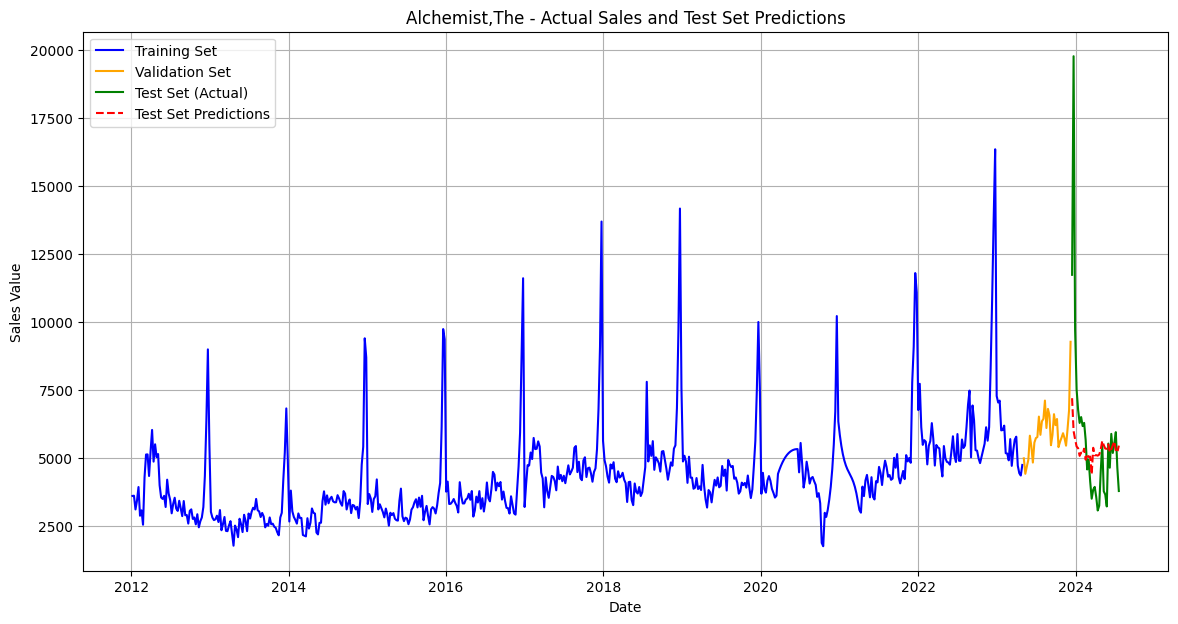

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


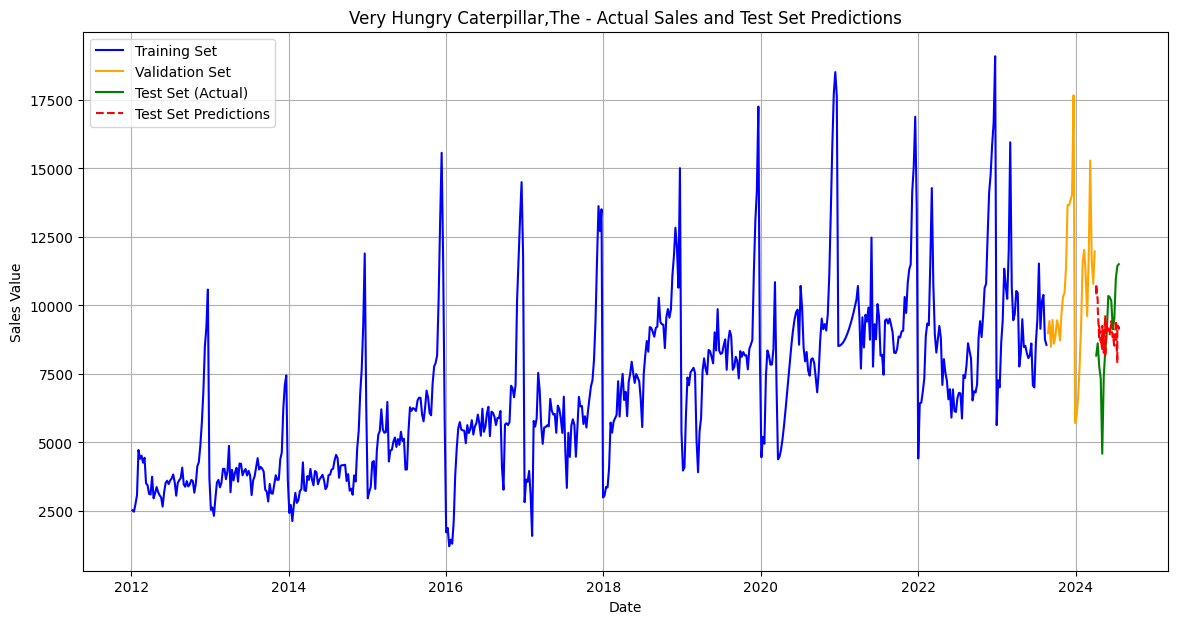

In [34]:
# Visualization: Plot Actual Sales and Test Set Predictions
for title, info in best_models.items():
    model = info['model']
    params = info['params']
    metrics = info['metrics']
    data = books_data[title]
    last_window = data['last_window']
    y_test = data['y_test']
    scaler = data['scaler']
    test_start_date = data['test_start_date']
    adjusted_test_end_date = data['adjusted_test_end_date']  # Ensure we use the adjusted test end date

    # Make predictions on the test set using last_window
    test_predicted = make_predictions(model, last_window, scaler)

    # Get the dates for the entire series
    book_df = two_books_sales_data[two_books_sales_data['Title'] == title].copy().sort_values('End Date')

    # Ensure 'End Date' index is in DatetimeIndex format
    book_df['End Date'] = pd.to_datetime(book_df['End Date'])
    book_df.set_index('End Date', inplace=True)

    full_series_dates = book_df.index
    full_series_values = book_df['Value']

    # Split full_series_values into training, validation, and test parts for plotting
    training_end_date = test_start_date - pd.Timedelta(weeks=forecast_horizon + validation_size)
    validation_end_date = test_start_date - pd.Timedelta(weeks=forecast_horizon)

    # Training set values and dates
    training_values = book_df.loc[:validation_end_date - pd.Timedelta(days=7)]['Value']
    training_dates = training_values.index

    # Validation set values and dates
    validation_values = book_df.loc[validation_end_date:test_start_date - pd.Timedelta(days=7)]['Value']
    validation_dates = validation_values.index

    # Test set values and dates
    test_values = book_df.loc[test_start_date:adjusted_test_end_date]['Value']
    test_dates = test_values.index

    # Plotting
    plt.figure(figsize=(14, 7))

    # Plot the training set
    plt.plot(training_dates, training_values, label='Training Set', color='blue')

    # Plot the validation set
    plt.plot(validation_dates, validation_values, label='Validation Set', color='orange')

    # Plot the test set actual values
    plt.plot(test_dates, test_values, label='Test Set (Actual)', color='green')

    # Plot the test set predictions
    plt.plot(test_dates, test_predicted, label='Test Set Predictions', color='red', linestyle='dashed')

    plt.title(f'{title} - Actual Sales and Test Set Predictions')
    plt.xlabel('Date')
    plt.ylabel('Sales Value')
    plt.legend()
    plt.grid(True)
    plt.show()


**Conculusions**

LSTM is not as good a predictor as GXBoost for either book. This is likely due to several factors, including setting the rolling window to 52 weeks and the use of a validation set which guards against overfitting the model.

#### Hybrid Models

We will now combine the SARIMA and LSTM approaches into a hybrid model, hopefully capturing all linear and non-linear trends in the data and increasing model robustness.

We will begin by running an LSTM model on the residuals of the most optimal SARIMA model found with auto-ARIMA.

The code below is incredibly inefficient. There are far better ways of doing this.

In [3]:
def arima_prepare_book_data(df, title, validation_size=84, test_start_date='2023-12-16'):
    """
    Prepares training, validation, and test datasets for an ARIMA model for a specific book.

    Parameters:
    - df: The entire DataFrame.
    - title: The title of the book to process.
    - validation_size: Number of weeks in the validation set.
    - test_start_date: Start date for the test set (inclusive).

    Returns:
    - training_set: Training dataset.
    - validation_set: Validation dataset.
    - test_set: Test dataset.
    """
    # Initialize book_df by filtering the DataFrame for the given title
    book_df = df[df['Title'] == title].copy()
    
    # Sort by 'End Date'
    book_df = book_df.sort_values('End Date')

    # Set 'End Date' as the index
    book_df.set_index('End Date', inplace=True)

    # Define test set: last 32 observations starting from `test_start_date`
    test_start_date = pd.to_datetime(test_start_date)
    test_set = book_df.loc[test_start_date:].tail(32)

    # Ensure that there are enough data points for test set
    if len(test_set) < 32:
        raise ValueError(f"Not enough data to create a test set for title '{title}'. Required: 32, Found: {len(test_set)}.")

    # Define validation set: `validation_size` weeks before the test set
    validation_end_date = test_set.index[0] - pd.Timedelta(days=7)
    validation_start = validation_end_date - pd.Timedelta(weeks=validation_size - 1)
    validation_set = book_df.loc[validation_start:validation_end_date]

    # Ensure that validation set has enough data points
    if len(validation_set) < validation_size:
        raise ValueError(f"Not enough data to create a validation set for title '{title}'. Required: {validation_size}, Found: {len(validation_set)}.")

    # Define training set: all data before the validation set
    training_end_date = validation_start - pd.Timedelta(days=7)
    training_set = book_df.loc[:training_end_date]

    # Ensure training set has enough data points
    if len(training_set) == 0:
        raise ValueError(f"No data available for training set for title '{title}'.")

    return training_set, validation_set, test_set

In [4]:
def run_auto_arima(df, titles, validation_size=84, test_start_date='2023-12-16'):
    """
    Runs auto-ARIMA on training, validation, and test splits for each book.

    Parameters:
    - df: The entire DataFrame.
    - titles: List of book titles to process.
    - validation_size: Number of weeks in the validation set.
    - test_start_date: Start date for the test set (inclusive).

    Returns:
    - residuals_dict: Dictionary containing residuals for training and validation for each book.
    - models_dict: Dictionary containing the fitted ARIMA models for each book.
    """
    residuals_dict = {}
    models_dict = {}

    for title in titles:
        print(f"\nProcessing {title}...")

        try:
            # Prepare data
            training_set, validation_set, test_set = arima_prepare_book_data(df, title, validation_size, test_start_date)
        except ValueError as e:
            print(e)
            continue

        # Extract the 'Value' series
        train = training_set['Value']
        val = validation_set['Value']
        test = test_set['Value']

        # Debugging statements
        print(f"Training set length for {title}: {len(train)}")
        print(f"Validation set length for {title}: {len(val)}")
        print(f"Test set length for {title}: {len(test)}")

        # Fit Auto ARIMA model on the training data
        model = auto_arima(
            train,
            start_p=1,
            max_p=3,
            start_q=1,
            max_q=3,
            start_P=1,
            max_P=3,
            start_Q=1,
            max_Q=3,
            max_order=5,
            m=52,
            seasonal=True,
            test='adf',
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True,
            information_criterion='aic',
            alpha=0.05,
            n_jobs=-1,
            maxiter=50
        )

        # Print the model summary
        print(model.summary())

        # Get residuals for training set
        fitted_values_train = model.predict_in_sample(start=0, end=len(train) - 1)
        residuals_train = train.values - fitted_values_train

        # Fit model on training + validation data
        combined_train_val = pd.concat([train, val])
        print(f"Combined training and validation set length for {title}: {len(combined_train_val)}")
        model.fit(combined_train_val)
        models_dict[title] = model

        # Get residuals for validation set
        fitted_values_val = model.predict(n_periods=len(val))
        residuals_val = val.values - fitted_values_val

        # Combine residuals from training and validation
        combined_residuals = np.concatenate([residuals_train, residuals_val])

        # Store combined residuals for the LSTM model
        residuals_dict[title] = pd.Series(combined_residuals)

    return residuals_dict, models_dict

In [5]:
def prepare_residual_data(residuals, window_size, forecast_horizon):
    """
    Prepares training, validation, and test datasets for the LSTM model using residuals.

    Parameters:
    - residuals: Residuals time series for a specific book.
    - window_size: Number of past weeks to use for prediction.
    - forecast_horizon: Number of weeks to forecast (test set size).

    Returns:
    - X_train, y_train: Training sequences.
    - last_window: Last `window_size` weeks from training + validation sets for forecasting.
    """
    # Ensure there are enough data points for the window size and forecast horizon
    if len(residuals) < window_size + forecast_horizon:
        raise ValueError(f"Not enough data to create sequences. Required: {window_size + forecast_horizon}, Found: {len(residuals)}.")

    # Initialize scaler and fit on residual data
    scaler = MinMaxScaler(feature_range=(0, 1))
    residuals_scaled = scaler.fit_transform(residuals.values.reshape(-1, 1))

    # Function to create sequences
    def create_sequences(data, window, horizon):
        X, y = [], []
        for i in range(window, len(data) - horizon + 1):
            X.append(data[i - window:i, 0])
            y.append(data[i:i + horizon, 0])
        return np.array(X), np.array(y)

    # Create sequences for training
    X_train, y_train = create_sequences(residuals_scaled[:-forecast_horizon], window_size, forecast_horizon)

    # **Reshape X_train to 3D**
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Prepare the last window for forecasting
    last_window = residuals_scaled[-window_size:].reshape((1, window_size, 1))

    # **Debugging: Print shapes to verify**
    print(f"X_train shape: {X_train.shape}")  # Should be (num_samples, window_size, 1)
    print(f"y_train shape: {y_train.shape}")  # Should be (num_samples, forecast_horizon)
    print(f"last_window shape: {last_window.shape}")  # Should be (1, window_size, 1)

    return X_train, y_train, last_window

In [6]:
def run_lstm_tuner(X_train, y_train, last_window, forecast_horizon):
    """
    Uses Keras Tuner to find the best LSTM model and forecasts residuals.

    Parameters:
    - X_train: Training sequences for LSTM (3D array).
    - y_train: Training labels for LSTM.
    - last_window: Last window of sequences for forecasting (3D array).
    - forecast_horizon: Number of weeks to forecast.

    Returns:
    - best_model: Trained best LSTM model.
    - predicted_residuals: Predicted residuals for the forecast horizon.
    """

    def build_lstm_model(hp):
        model = Sequential()

        # First LSTM layer
        model.add(LSTM(
            units=hp.Int('units_1', min_value=32, max_value=128, step=32),
            activation='relu',
            return_sequences=True,
            input_shape=(X_train.shape[1], X_train.shape[2])  # Now X_train is 3D
        ))
        model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

        # Second LSTM layer (stacked)
        model.add(LSTM(
            units=hp.Int('units_2', min_value=32, max_value=128, step=32),
            activation='relu'
        ))
        model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

        # Output layer
        model.add(Dense(forecast_horizon))  # The output layer has 'forecast_horizon' units since we are predicting multiple time steps ahead

        # Compile the model
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        return model

    tuner = kt.RandomSearch(
        build_lstm_model,
        objective='val_loss',
        max_trials=10,
        executions_per_trial=1,
        directory='lstm_tuner',
        project_name='lstm_hyperparameter_search'
    )

    # Search for the best model
    tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, verbose=1)

    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Build the best model
    best_model = tuner.hypermodel.build(best_hps)
    history = best_model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32)

    # Summary of the best model
    best_model.summary()

    # Predict using the best model
    predicted_residuals = best_model.predict(last_window)

    return best_model, predicted_residuals


In [7]:
def sequential_model(df, title, validation_size=84, test_start_date='2023-12-16', window_size=52, forecast_horizon=32):
    """
    Runs a sequential hybrid model (Auto-ARIMA + LSTM) for a given book title.

    Parameters:
    - df: The entire DataFrame.
    - title: The title of the book to process.
    - validation_size: Number of weeks in the validation set.
    - test_start_date: Start date for the test set (inclusive).
    - window_size: Number of past weeks to use for prediction in LSTM.
    - forecast_horizon: Number of weeks to forecast.
    """
    # Run Auto-ARIMA and get residuals and models
    residuals_dict, models_dict = run_auto_arima(df, [title], validation_size, test_start_date)

    if title in residuals_dict:
        residuals = residuals_dict[title]
        arima_model = models_dict[title]

        # Prepare residual data for LSTM
        X_train, y_train, last_window = prepare_residual_data(residuals, window_size, forecast_horizon)

        # Run LSTM tuner and get the best model
        best_model, predicted_residuals = run_lstm_tuner(X_train, y_train, last_window, forecast_horizon)
        predicted_residuals = predicted_residuals.flatten()

        # Get ARIMA forecast
        arima_forecast = arima_model.predict(n_periods=forecast_horizon)

        # Combine ARIMA and LSTM forecasts
        final_forecast = arima_forecast + predicted_residuals

        # **Retrieve Training and Validation Sets**
        training_set, validation_set, _ = arima_prepare_book_data(df, title, validation_size, test_start_date)

        # **Plot the Final Forecast Along with Training and Validation Data**
        forecast_index = pd.date_range(start=test_start_date, periods=forecast_horizon, freq='W-SAT')
        plt.figure(figsize=(14, 7))

        # Plot Training Data
        plt.plot(training_set.index, training_set['Value'], label='Training Data', color='blue')

        # Plot Validation Data
        plt.plot(validation_set.index, validation_set['Value'], label='Validation Data', color='green')

        # Plot Final Combined Forecast
        plt.plot(forecast_index, final_forecast, label='Final Combined Forecast', color='purple', linestyle='--')

        # Enhance Plot
        plt.title(f'Final Combined Forecast (Auto-ARIMA + LSTM) for "{title}"', fontsize=16)
        plt.xlabel('End Date', fontsize=14)
        plt.ylabel('Value', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # **Evaluate the Final Model**
        test_set = df[(df['Title'] == title) & (df['End Date'] >= test_start_date)].head(forecast_horizon)
        test_values = test_set['Value'].values
        mae_combined = mean_absolute_error(test_values, final_forecast)
        mape_combined = mean_absolute_percentage_error(test_values, final_forecast)
        print(f'Combined MAE for "{title}": {mae_combined:.2f}')
        print(f'Combined MAPE for "{title}": {mape_combined:.2f}%')
    else:
        print(f"No residuals found for title '{title}'.")

In [8]:
def prepare_lstm_data(values, window_size, forecast_horizon):
    """
    Prepares training and forecasting data for the LSTM model using actual values.
    
    Parameters:
    - values: Time series values for a specific book.
    - window_size: Number of past weeks to use for prediction.
    - forecast_horizon: Number of weeks to forecast.
    
    Returns:
    - X_train, y_train: Training sequences.
    - last_window: Last `window_size` weeks from training + validation sets for forecasting.
    - scaler: Fitted MinMaxScaler object.
    """
    # Ensure there are enough data points for the window size and forecast horizon
    if len(values) < window_size + forecast_horizon:
        raise ValueError(f"Not enough data to create sequences. Required: {window_size + forecast_horizon}, Found: {len(values)}.")
    
    # Initialize scaler and fit on actual values
    scaler = MinMaxScaler(feature_range=(0, 1))
    values_scaled = scaler.fit_transform(values.values.reshape(-1, 1))
    
    # Function to create sequences
    def create_sequences(data, window, horizon):
        X, y = [], []
        for i in range(window, len(data) - horizon + 1):
            X.append(data[i - window:i, 0])
            y.append(data[i:i + horizon, 0])
        return np.array(X), np.array(y)
    
    # Create sequences for training
    X_train, y_train = create_sequences(values_scaled[:-forecast_horizon], window_size, forecast_horizon)
    
    # Reshape X_train to 3D
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    
    # Prepare the last window for forecasting
    last_window = values_scaled[-window_size:].reshape((1, window_size, 1))
    
    # Debugging: Print shapes to verify
    print(f"After reshaping:")
    print(f"X_train shape: {X_train.shape}")  # Expected: (num_samples, window_size, 1)
    print(f"y_train shape: {y_train.shape}")  # Expected: (num_samples, forecast_horizon)
    print(f"last_window shape: {last_window.shape}")  # Expected: (1, window_size, 1)
    
    return X_train, y_train, last_window, scaler


In [9]:
def run_lstm_tuner_parallel(X_train, y_train, last_window, forecast_horizon):
    """
    Uses Keras Tuner to find the best LSTM model trained on actual values and forecasts residuals.
    
    Parameters:
    - X_train: Training sequences for LSTM (3D array).
    - y_train: Training labels for LSTM.
    - last_window: Last window of sequences for forecasting (3D array).
    - forecast_horizon: Number of weeks to forecast.
    
    Returns:
    - best_model: Trained best LSTM model.
    - predicted_values: Predicted values for the forecast horizon.
    - scaler: Fitted MinMaxScaler object used for scaling.
    """
    
    def build_lstm_model(hp):
        model = Sequential()

        # First LSTM layer
        model.add(LSTM(
            units=hp.Int('units_1', min_value=32, max_value=128, step=32),
            activation='relu',
            return_sequences=True,
            input_shape=(X_train.shape[1], X_train.shape[2])  # Now X_train is 3D
        ))
        model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

        # Second LSTM layer (stacked)
        model.add(LSTM(
            units=hp.Int('units_2', min_value=32, max_value=128, step=32),
            activation='relu'
        ))
        model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

        # Output layer
        model.add(Dense(forecast_horizon))  # The output layer has 'forecast_horizon' units since we are predicting multiple time steps ahead

        # Compile the model
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        return model

    tuner = kt.RandomSearch(
        build_lstm_model,
        objective='val_loss',
        max_trials=10,
        executions_per_trial=1,
        directory='lstm_tuner_parallel',
        project_name='lstm_hyperparameter_search_parallel'
    )

    # Search for the best model
    tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, verbose=1)

    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Build the best model
    best_model = tuner.hypermodel.build(best_hps)
    history = best_model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=1)

    # Summary of the best model
    best_model.summary()

    # Predict using the best model
    predicted_values = best_model.predict(last_window)

    return best_model, predicted_values


In [10]:
def parallel_model(df, title, validation_size=84, test_start_date='2023-12-16', window_size=52, forecast_horizon=32, weighted_average=0.5):
    """
    Runs a parallel hybrid model (Auto-ARIMA + LSTM) for a given book title.
    
    Parameters:
    - df: The entire DataFrame.
    - title: The title of the book to process.
    - validation_size: Number of weeks in the validation set.
    - test_start_date: Start date for the test set (inclusive).
    - window_size: Number of past weeks to use for prediction in LSTM.
    - forecast_horizon: Number of weeks to forecast.
    - weighted_average: Weight assigned to the ARIMA forecast in the final combination.
    
    Returns:
    - None
    """
    # Run Auto-ARIMA and get residuals and models
    residuals_dict, models_dict = run_auto_arima(df, [title], validation_size, test_start_date)

    if title in residuals_dict:
        residuals = residuals_dict[title]
        arima_model = models_dict[title]

        # Prepare data for LSTM trained on actual values
        # Retrieve the original data used for ARIMA
        book_df = df[df['Title'] == title].copy()
        book_df = book_df.sort_values('End Date')
        book_df.set_index('End Date', inplace=True)
        
        # Define training + validation set for LSTM (same as ARIMA's training + validation)
        training_set, validation_set, _ = arima_prepare_book_data(df, title, validation_size, test_start_date)
        train_val_end_date = validation_set.index[-1]
        train_val_data = book_df.loc[:train_val_end_date]['Value']
        
        # Prepare LSTM data
        X_train_lstm, y_train_lstm, last_window_lstm, scaler_lstm = prepare_lstm_data(train_val_data, window_size, forecast_horizon)

        # Run LSTM tuner and get the best model
        best_model_lstm, predicted_values_lstm = run_lstm_tuner_parallel(X_train_lstm, y_train_lstm, last_window_lstm, forecast_horizon)
        predicted_values_lstm = predicted_values_lstm.flatten()

        # Get ARIMA forecast
        arima_forecast = arima_model.predict(n_periods=forecast_horizon)
        
        # Convert arima_forecast to NumPy array if it's a Series or DataFrame
        if isinstance(arima_forecast, pd.Series):
            arima_forecast = arima_forecast.to_numpy()
        elif isinstance(arima_forecast, pd.DataFrame):
            arima_forecast = arima_forecast.values.flatten()
        elif isinstance(arima_forecast, list):
            arima_forecast = np.array(arima_forecast)
        # Else, assume it's already a NumPy array or similar
        
        # Ensure arima_forecast is a 1D array
        arima_forecast = np.ravel(arima_forecast)  # Safely flattens to 1D

        # Combine ARIMA and LSTM forecasts using weighted average
        final_forecast = weighted_average * arima_forecast + (1 - weighted_average) * predicted_values_lstm

        # Plot the Final Forecast Along with Training and Validation Data
        forecast_index = pd.date_range(start=test_start_date, periods=forecast_horizon, freq='W-SAT')
        plt.figure(figsize=(14, 7))

        # Plot Training Data
        plt.plot(training_set.index, training_set['Value'], label='Training Data', color='blue')

        # Plot Validation Data
        plt.plot(validation_set.index, validation_set['Value'], label='Validation Data', color='green')

        # Plot Final Combined Forecast
        plt.plot(forecast_index, final_forecast, label='Final Combined Forecast', color='purple', linestyle='--')

        # Enhance Plot
        plt.title(f'Final Combined Forecast (Auto-ARIMA + LSTM) for "{title}"', fontsize=16)
        plt.xlabel('End Date', fontsize=14)
        plt.ylabel('Value', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # **Evaluate the Final Model**
        test_set = df[(df['Title'] == title) & (df['End Date'] >= test_start_date)].head(forecast_horizon)
        test_values = test_set['Value'].values

        # **Ensure final_forecast is in the same scale as test_values**
        # If LSTM predictions were scaled, inverse transform them
        # However, in run_lstm_tuner_parallel, predictions are on the same scale as ARIMA
        # So, assuming no scaling differences

        # Calculate Evaluation Metrics
        mae_combined = mean_absolute_error(test_values, final_forecast)
        mape_combined = mean_absolute_percentage_error(test_values, final_forecast)

        print(f'Combined MAE for "{title}": {mae_combined:.2f}')
        print(f'Combined MAPE for "{title}": {mape_combined:.2f}%')
    else:
        print(f"No residuals found for title '{title}'.")


Processing Alchemist,The...
Training set length for Alchemist,The: 539
Validation set length for Alchemist,The: 84
Test set length for Alchemist,The: 32
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  539
Model:             SARIMAX(2, 0, 2)x(2, 0, [], 52)   Log Likelihood               -4271.436
Date:                             Sat, 05 Oct 2024   AIC                           8556.871
Time:                                     14:18:00   BIC                           8586.899
Sample:                                 01-07-2012   HQIC                          8568.616
                                      - 04-30-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 52, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 52, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         4,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 359,522 (1.37 MB)

 Trainable params: 119,840 (468.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 239,682 (936.26 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


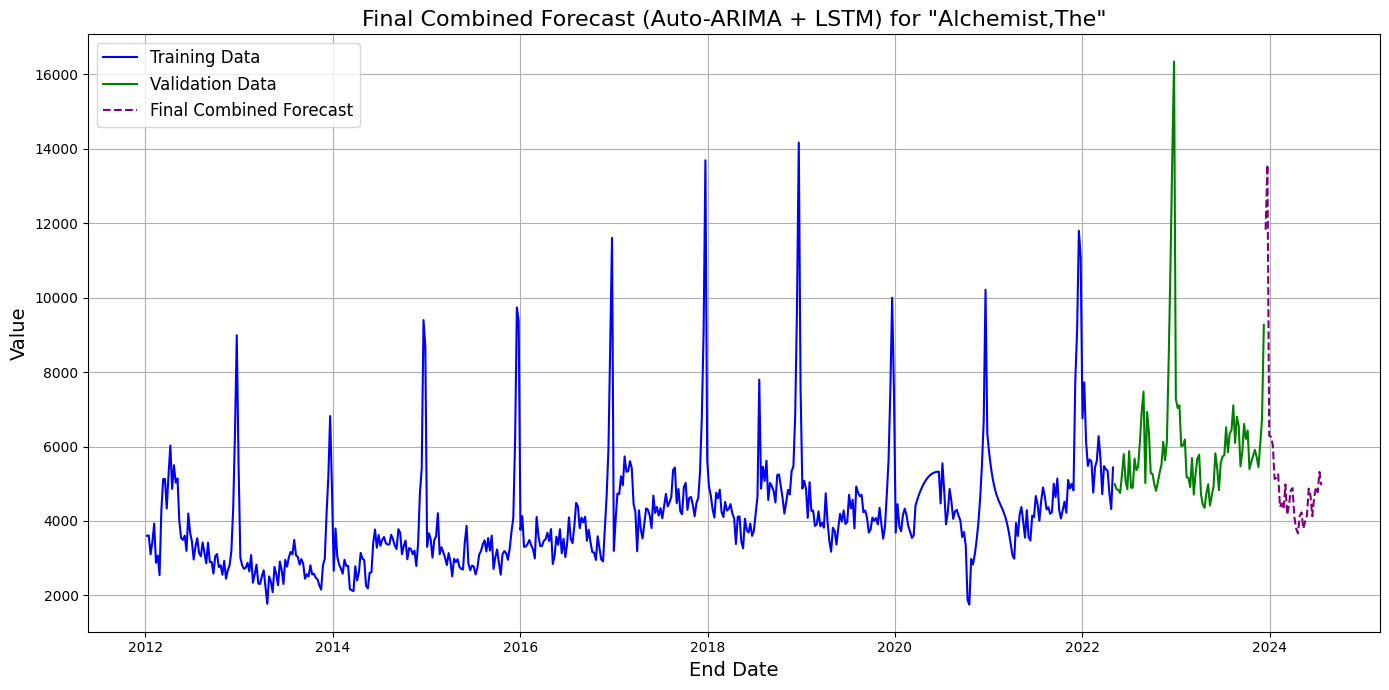

Combined MAE for "Alchemist,The": 1022.41
Combined MAPE for "Alchemist,The": 0.17%


In [44]:
# Run sequential_model for The Alchemist
sequential_model(
    df=two_books_sales_data,
    title="Alchemist,The", 
    validation_size=84, 
    test_start_date='2023-12-16', 
    window_size=52, 
    forecast_horizon=32
)


Processing Alchemist,The...
Training set length for Alchemist,The: 539
Validation set length for Alchemist,The: 84
Test set length for Alchemist,The: 32
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  539
Model:             SARIMAX(2, 0, 2)x(2, 0, [], 52)   Log Likelihood               -4271.436
Date:                             Sat, 05 Oct 2024   AIC                           8556.871
Time:                                     15:01:45   BIC                           8586.899
Sample:                                 01-07-2012   HQIC                          8568.616
                                      - 04-30-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 52, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 52, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         3,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,194 (1.79 MB)

 Trainable params: 156,064 (609.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 312,130 (1.19 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


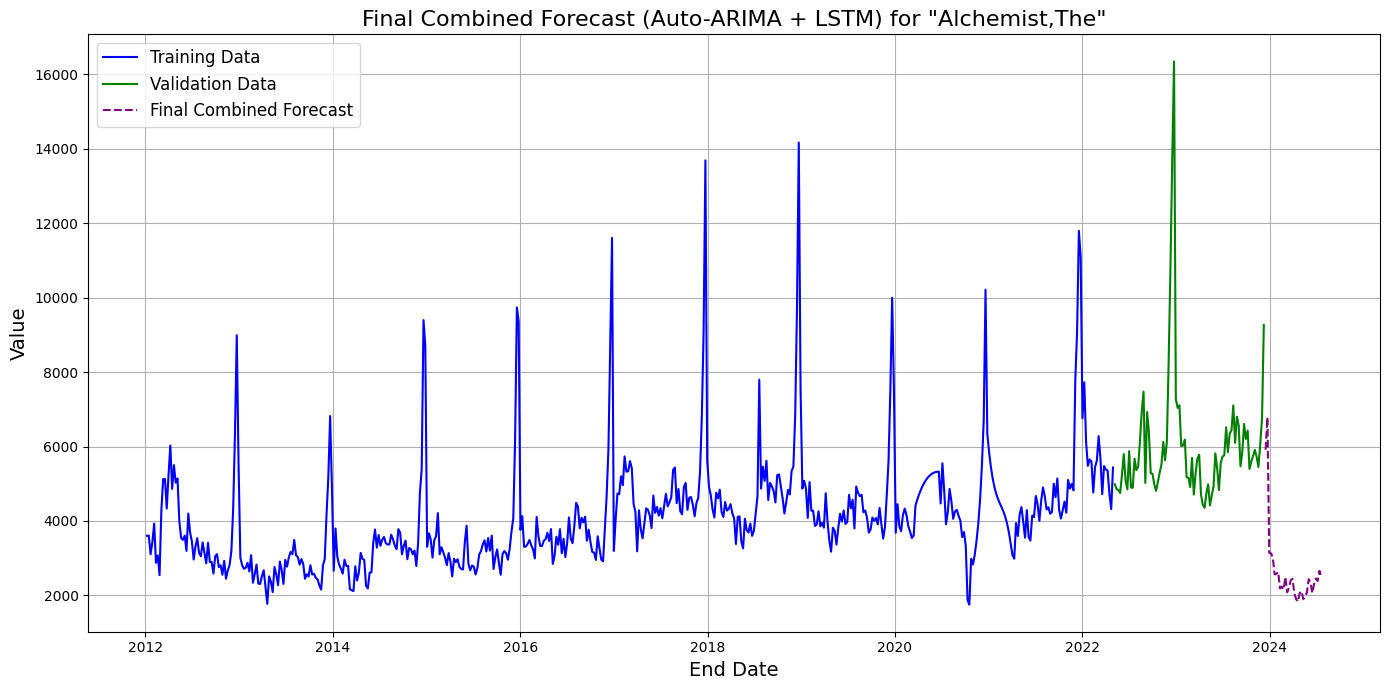

Combined MAE for "Alchemist,The": 3123.90
Combined MAPE for "Alchemist,The": 0.52%


In [45]:
parallel_model(
    df=two_books_sales_data,
    title="Alchemist,The",
    validation_size=84,
    test_start_date='2023-12-16',
    window_size=52,
    forecast_horizon=32,
    weighted_average=0.5
)


Processing Alchemist,The...
Training set length for Alchemist,The: 539
Validation set length for Alchemist,The: 84
Test set length for Alchemist,The: 32
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  539
Model:             SARIMAX(2, 0, 2)x(2, 0, [], 52)   Log Likelihood               -4271.436
Date:                             Sat, 05 Oct 2024   AIC                           8556.871
Time:                                     15:44:34   BIC                           8586.899
Sample:                                 01-07-2012   HQIC                          8568.616
                                      - 04-30-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 52, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 52, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         3,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,194 (1.79 MB)

 Trainable params: 156,064 (609.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 312,130 (1.19 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


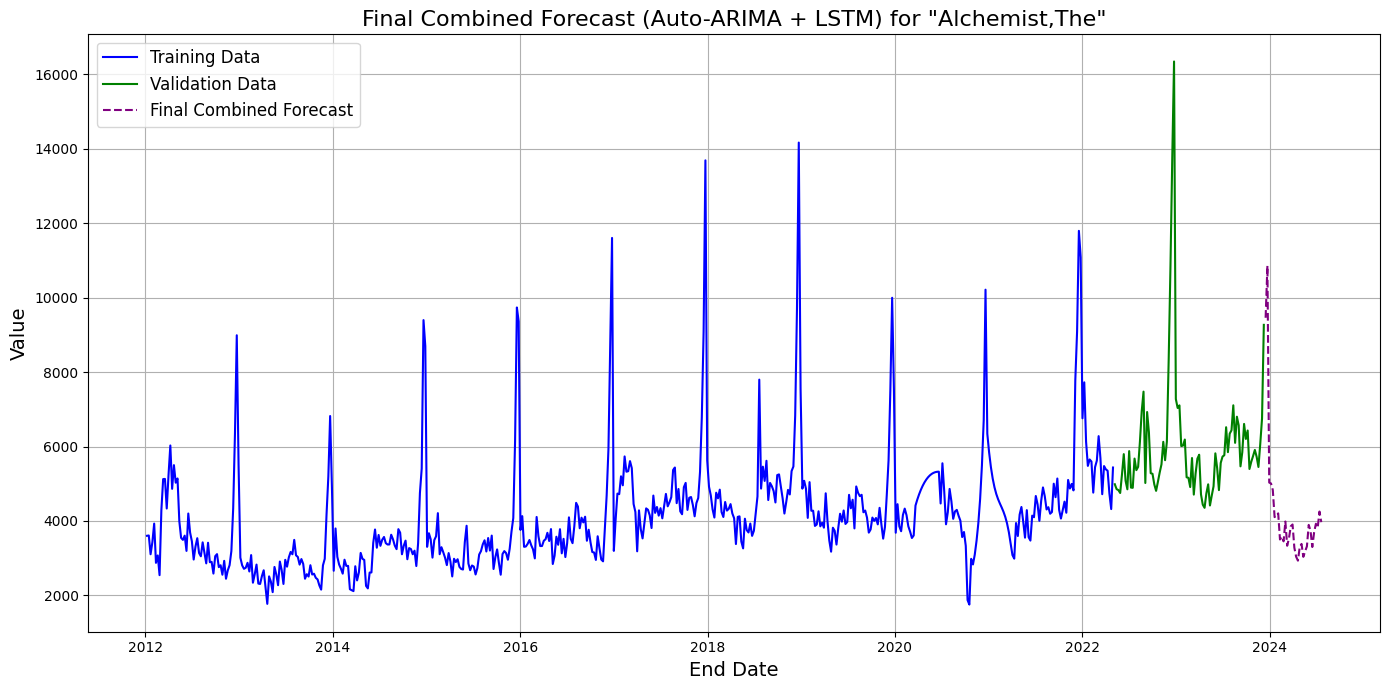

Combined MAE for "Alchemist,The": 1589.09
Combined MAPE for "Alchemist,The": 0.23%


In [46]:
parallel_model(
    df=two_books_sales_data,
    title="Alchemist,The",
    validation_size=84,
    test_start_date='2023-12-16',
    window_size=52,
    forecast_horizon=32,
    weighted_average=0.8
)


Processing Very Hungry Caterpillar,The...
Training set length for Very Hungry Caterpillar,The: 1110
Validation set length for Very Hungry Caterpillar,The: 168
Test set length for Very Hungry Caterpillar,The: 32
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1110
Model:             SARIMAX(2, 0, 1)x(2, 0, [], 52)   Log Likelihood               -9031.955
Date:                             Sat, 05 Oct 2024   AIC                          18077.911
Time:                                     17:03:18   BIC                          18112.996
Sample:                                          0   HQIC                         18091.178
                                            - 1110                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 52, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 52, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         4,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 359,522 (1.37 MB)

 Trainable params: 119,840 (468.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 239,682 (936.26 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


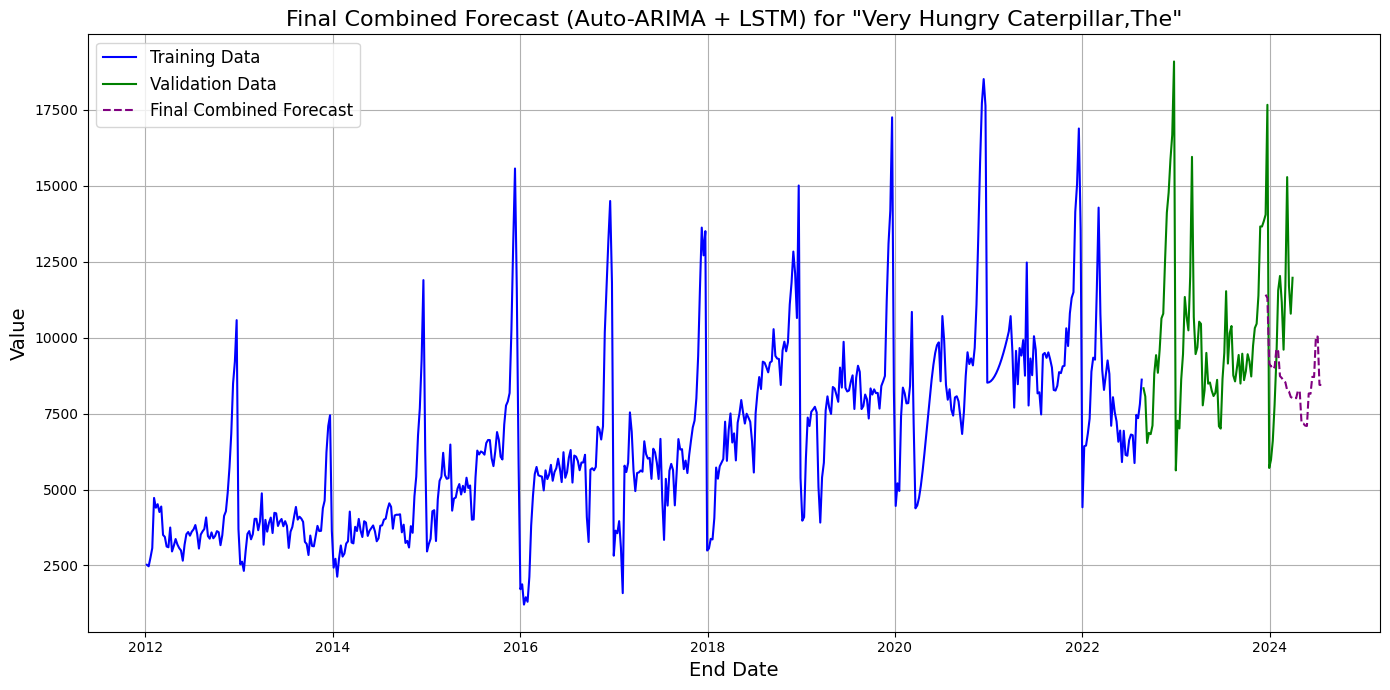

Combined MAE for "Very Hungry Caterpillar,The": 3377.37
Combined MAPE for "Very Hungry Caterpillar,The": 0.31%


In [47]:
# Run sequential_model for The Alchemist
sequential_model(
    df=two_books_sales_data,
    title="Very Hungry Caterpillar,The", 
    validation_size=84, 
    test_start_date='2023-12-16', 
    window_size=52, 
    forecast_horizon=32
)


Processing Very Hungry Caterpillar,The...
Training set length for Very Hungry Caterpillar,The: 1110
Validation set length for Very Hungry Caterpillar,The: 168
Test set length for Very Hungry Caterpillar,The: 32
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1110
Model:             SARIMAX(2, 0, 1)x(2, 0, [], 52)   Log Likelihood               -9031.955
Date:                             Sat, 05 Oct 2024   AIC                          18077.911
Time:                                     18:11:18   BIC                          18112.996
Sample:                                          0   HQIC                         18091.178
                                            - 1110                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 52, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 52, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         3,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,194 (1.79 MB)

 Trainable params: 156,064 (609.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 312,130 (1.19 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


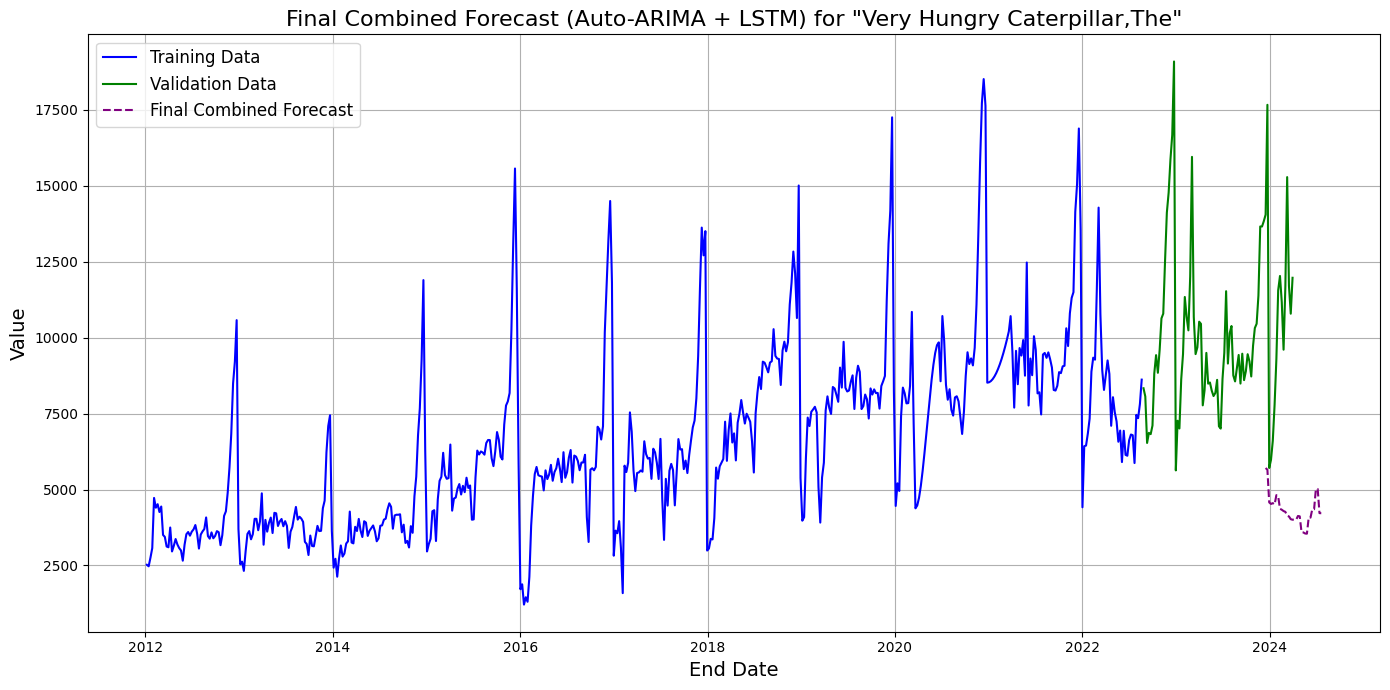

Combined MAE for "Very Hungry Caterpillar,The": 6479.06
Combined MAPE for "Very Hungry Caterpillar,The": 0.56%


In [48]:
parallel_model(
    df=two_books_sales_data,
    title="Very Hungry Caterpillar,The",
    validation_size=84,
    test_start_date='2023-12-16',
    window_size=52,
    forecast_horizon=32,
    weighted_average=0.5
)


Processing Very Hungry Caterpillar,The...
Training set length for Very Hungry Caterpillar,The: 1110
Validation set length for Very Hungry Caterpillar,The: 168
Test set length for Very Hungry Caterpillar,The: 32
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1110
Model:             SARIMAX(2, 0, 1)x(2, 0, [], 52)   Log Likelihood               -9031.955
Date:                             Sun, 06 Oct 2024   AIC                          18077.911
Time:                                     17:07:19   BIC                          18112.996
Sample:                                          0   HQIC                         18091.178
                                            - 1110                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 52, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 52, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         3,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,194 (1.79 MB)

 Trainable params: 156,064 (609.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 312,130 (1.19 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


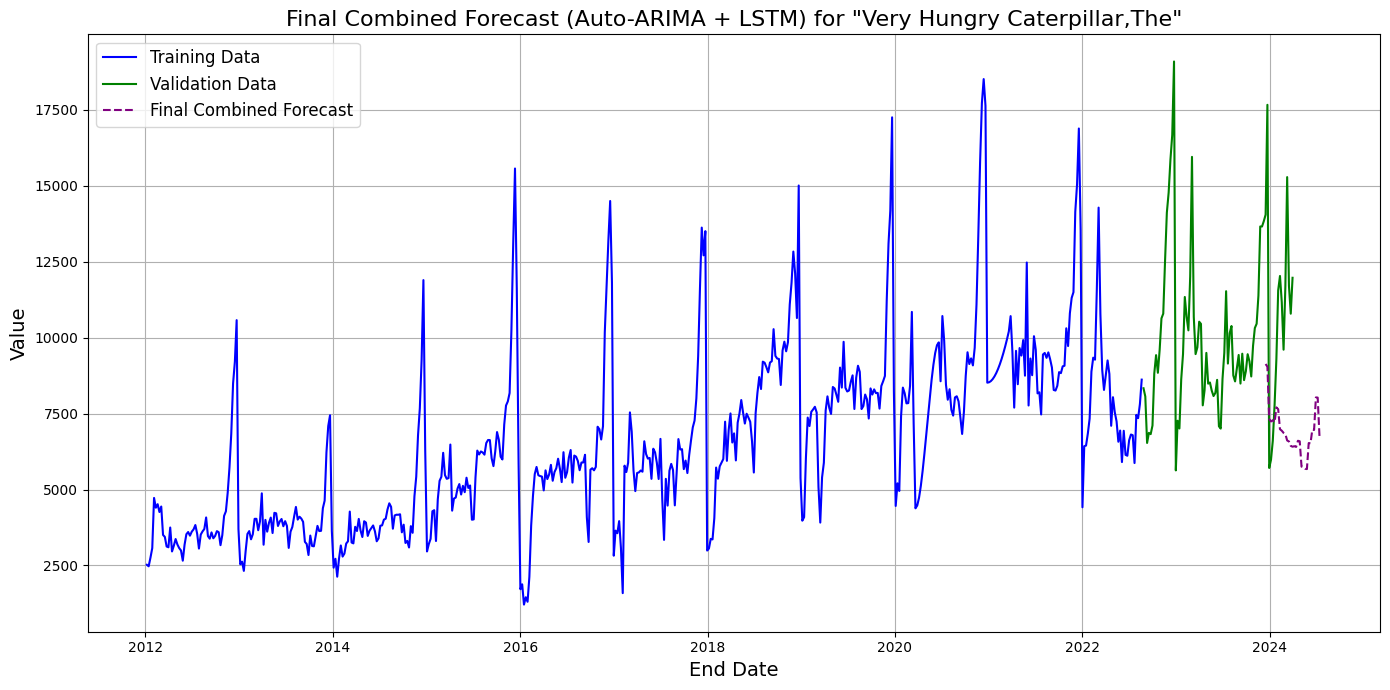

Combined MAE for "Very Hungry Caterpillar,The": 4329.81
Combined MAPE for "Very Hungry Caterpillar,The": 0.37%


In [11]:
parallel_model(
    df=two_books_sales_data,
    title="Very Hungry Caterpillar,The",
    validation_size=84,
    test_start_date='2023-12-16',
    window_size=52,
    forecast_horizon=32,
    weighted_average=0.8
)